In [ ]:
## constructing a political compass from bottom up

In [2]:
import tensorflow as tf

In [ ]:
## so a whole bunch of layers between input data and output predictions (of voting behaviour/party preference)

## with a bottleneck 'encoding' layer

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.1


In [5]:
# %%time
dataset_name = "W29_only"
df_list = "BES_Panel|BES_reduced_with_na"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}

global BES_label_list, BES_df_list

Toggle code

var_type (474, 13)


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [90]:
predictions = model(x_train[:1]).numpy()
predictions

AttributeError: 'tuple' object has no attribute 'rank'

In [6]:
tf.nn.softmax(predictions).numpy()

array([[0.06975484, 0.14062317, 0.06632995, 0.0683215 , 0.10173128,
        0.09726133, 0.14259365, 0.11832036, 0.09792899, 0.09713496]],
      dtype=float32)

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
loss_fn(y_train[:1], predictions).numpy()

2.3303537

In [9]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [10]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2940 - accuracy: 0.9150
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1396 - accuracy: 0.9589
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1054 - accuracy: 0.9677
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0865 - accuracy: 0.9728
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0731 - accuracy: 0.9775


In [11]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0807 - accuracy: 0.9761 - 487ms/epoch - 2ms/step


[0.08072218298912048, 0.9761000275611877]

E:\Users\Gamer\anaconda3\envs\tf-n-gpu\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
E:\Users\Gamer\anaconda3\envs\tf-n-gpu\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


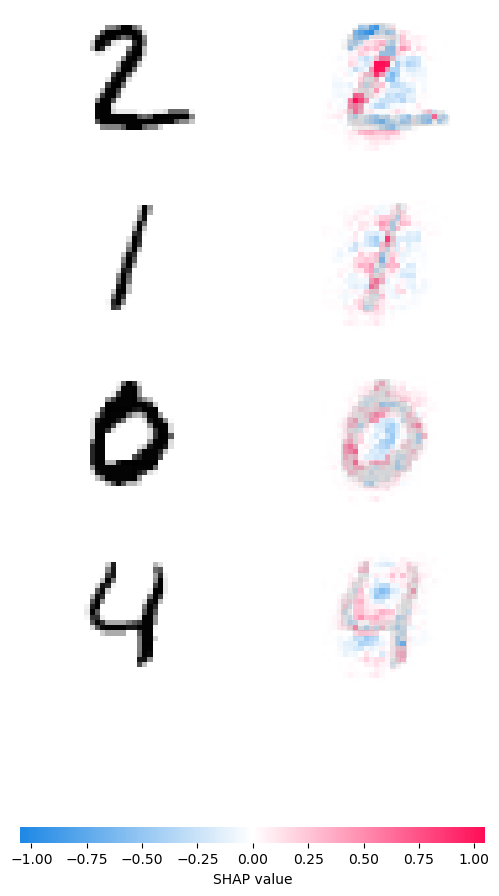

In [12]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

Toggle code

var_type (474, 13)


<Figure size 640x480 with 0 Axes>

In [44]:
BES_Panel["genElecTurnoutRetro"].cat.categories

Index(['No, did not vote', 'Yes, voted', 'Don't know'], dtype='object')

In [154]:
replace_dict = {'Labour':"LAB", 'Conservative':"CON", 'Brexit Party/Reform UK':"REF",
                  'Liberal Democrat':"LD", 'Green Party':"GP", 'Other':np.nan,
                  'An independent candidate':np.nan, "Don't know":np.nan,
                  'Scottish National Party (SNP)':np.nan, 'Plaid Cymru':np.nan}

y = BES_Panel["generalElectionVote"].astype('object')
y.loc[BES_Panel["genElecTurnoutRetro"]=='No, did not vote'] = "DNV"
y=y.replace(replace_dict).astype('category')

mask = (BES_Panel["country"]=="England")&y.notnull()
y=y[mask]
X = BES_reduced_with_na.drop(search(BES_reduced_with_na,"generalElectionVote|genElecTurnoutRetro").index,axis=1)[mask]
# X = X.dropna(axis=1)
X = (X-X.mean())/X.std()
keep_cols = X.columns[X.notnull().mean()>.6]
X = X[keep_cols].fillna(X[keep_cols].mean())

from tensorflow.keras.utils import to_categorical
y = to_categorical(y.cat.codes)

In [14]:
y_categories = ['CON', 'DNV', 'GP', 'LAB', 'LD', 'REF']

<Axes: >

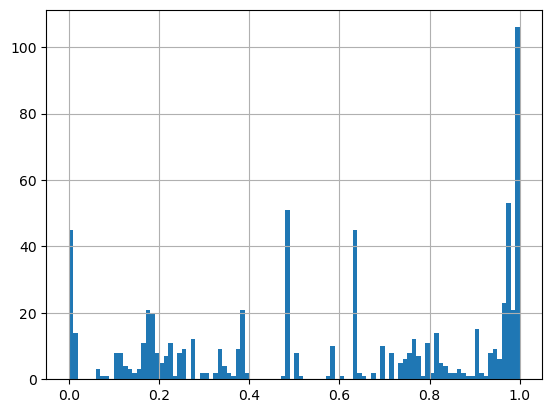

In [118]:
X.notnull().mean().hist(bins=100)

In [46]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0

x_train, x_test, y_train, y_test = train_test_split(X, y)

In [47]:
x_train.dtypes.value_counts()

float64    731
Name: count, dtype: int64

In [109]:
y_train.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

In [ ]:
## make life easier
# only English data - and drop smaller categories - but include Did Not Vote

In [55]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
import time

In [110]:
from tensorflow import keras
num_classes = len( y_train.unique() )

y_train = keras.utils.to_categorical(y_train.cat.codes, num_classes)
y_test = keras.utils.to_categorical(y_test.cat.codes, num_classes)

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

Epoch 1/15
627/627 [==============================] - 2s 3ms/step - loss: 0.6652 - accuracy: 0.7574 - val_loss: 0.5713 - val_accuracy: 0.7994
Epoch 2/15
627/627 [==============================] - 2s 3ms/step - loss: 0.4611 - accuracy: 0.8299 - val_loss: 0.5902 - val_accuracy: 0.8006
Epoch 3/15
627/627 [==============================] - 2s 3ms/step - loss: 0.3703 - accuracy: 0.8636 - val_loss: 0.6165 - val_accuracy: 0.7782
Epoch 4/15
627/627 [==============================] - 2s 3ms/step - loss: 0.3034 - accuracy: 0.8850 - val_loss: 0.6162 - val_accuracy: 0.7958


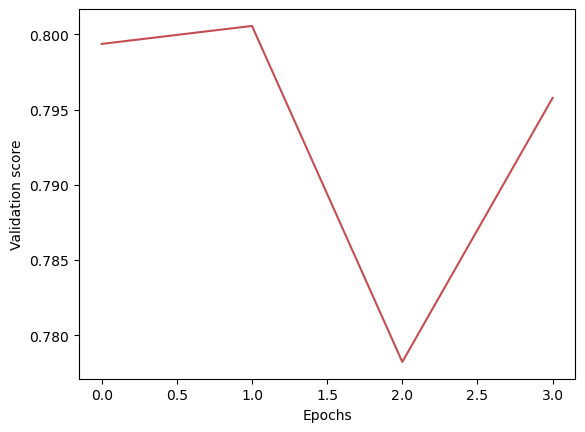

7.489033222198486


In [155]:
start_time = time.time()

early_stopping_monitor = EarlyStopping(patience=3)

n_neurons_layer = 500

# Create the model: model
model = Sequential()

# Add the first hidden layer
input_shape = (X.shape[1],)
model.add( Dense(n_neurons_layer, activation='relu', input_shape = input_shape) )

# Add the second hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the third hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the fourth hidden layer
model.add( Dense(n_neurons_layer, activation='relu') )

# Add the output layer
# no_of_outputs = len(np.unique(y))
model.add( Dense( num_classes , activation='softmax') )
# model.add( Dense( num_classes) )

# Compile the model
model.compile( 
               # optimizer = keras.optimizers.Adadelta(),
               optimizer = 'adam',
               loss = 'categorical_crossentropy',
                # loss=keras.losses.categorical_crossentropy,
               metrics=['accuracy'])

# Fit the model
# X -> X.values
model_training = model.fit(X, y,
                           epochs=15,
                           validation_split=0.2,
                           callbacks=[early_stopping_monitor],
                           verbose=True
                          )

# Create the plot
plt.plot(model_training.history['val_accuracy'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

elapsed_time = time.time() - start_time
print(elapsed_time)

In [130]:
predictions = model.predict(X)


array([[9.99054134e-01, 1.59492076e-04, 1.21697449e-04, 1.74043482e-04,
        4.40977834e-04, 4.97025321e-05],
       [2.87304312e-04, 1.40368415e-04, 4.19222983e-03, 6.48368180e-01,
        3.46832246e-01, 1.79776369e-04],
       [9.70731676e-03, 4.73292632e-04, 3.02106515e-02, 9.51520324e-01,
        1.90627750e-03, 6.18222030e-03],
       ...,
       [4.36326955e-03, 1.16772214e-02, 1.06654558e-02, 6.42461061e-01,
        1.14392452e-01, 2.16440484e-01],
       [2.71820492e-04, 5.78855215e-05, 2.94058328e-03, 2.82431334e-01,
        7.13202238e-01, 1.09606888e-03],
       [8.59142310e-05, 5.74626611e-05, 1.23549186e-01, 8.70419443e-01,
        5.86004602e-03, 2.79176802e-05]], dtype=float32)

In [144]:
pred_ser = pd.Series([y_categories[np.argmax(x)] for x in predictions])
pred_ser

0        CON
1        LAB
2        LAB
3        CON
4        CON
        ... 
25063    DNV
25064    LAB
25065    LAB
25066     LD
25067    LAB
Length: 25068, dtype: object

In [146]:
pred_ser.value_counts()

LAB    8738
CON    4721
REF    3976
DNV    3151
LD     2973
GP     1509
Name: count, dtype: int64

In [149]:
y.value_counts()

generalElectionVote
LAB    8012
CON    5048
REF    3611
DNV    3409
LD     3208
GP     1780
Name: count, dtype: int64

In [156]:
# select a set of background examples to take an expectation over
# background = X.loc[np.random.choice(X.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, X.values)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)


ValueError: zero-size array to reduction operation maximum which has no identity

In [159]:
%%time
shap_values = e.shap_values(X[::100].values)

## slow!

CPU times: total: 5min 12s
Wall time: 5min 16s


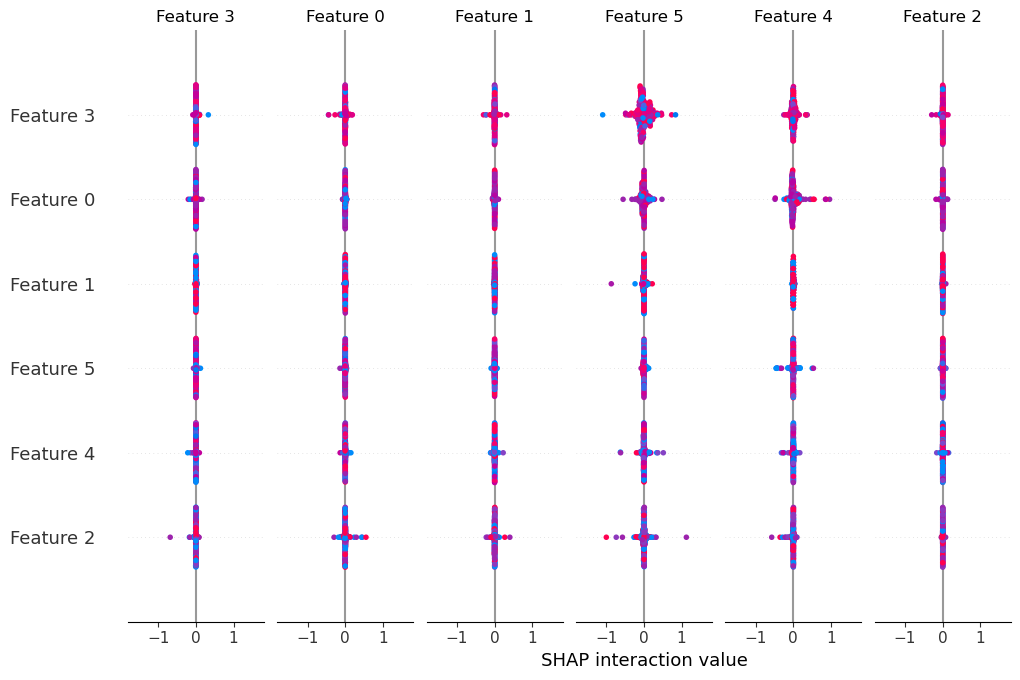

CPU times: total: 625 ms
Wall time: 660 ms


In [163]:
%%time
shap.summary_plot(shap_values, X[::100].values, plot_type='dot')

In [165]:
model.predict_proba

<bound method Sequential.predict_proba of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000002CA54302320>>

In [168]:
background = X.sample(100)
background

partyIdStrength__Not very strong  \
id                                         
36341                       1.243394e+00   
109439                     -2.576644e-01   
77730                      -2.576644e-01   
48416                       1.243394e+00   
54982                      -6.451101e-17   
...                                  ...   
81052                      -6.451101e-17   
76554                      -1.758722e+00   
73671                      -6.451101e-17   
89124                      -6.451101e-17   
8807                       -2.576644e-01   

        anyUniW26W27__Yes, I graduated from higher education  \
id                                                             
36341                                        9.787233e-01      
109439                                      -1.146794e+00      
77730                                        2.559233e-17      
48416                                        9.787233e-01      
54982                                        9.787233e-01      
...                                                   ...      
81052                                       -1.146794e+00      
76554                                        2.559233e-17      
73671                                       -1.146794e+00      
89124                                       -1.146794e+00      
8807                                         9.787233e-01      

        voteMethoda__Someone else voted for me (proxy voting)  \
id                                                              
36341                                        1.382971e+00       
109439                                      -1.073362e+00       
77730                                       -1.073362e+00       
48416                                        1.548042e-01       
54982                                       -6.694874e-17       
...                                                   ...       
81052                                       -1.073362e+00       
76554                                       -1.073362e+00       
73671                                       -1.073362e+00       
89124                                       -6.694874e-17       
8807                                         1.548042e-01       

        polAttention__Pay a great deal of attention  likeSunak__Strongly like  \
id                                                                              
36341                                      1.468164                  0.269141   
109439                                     0.270940                 -1.140018   
77730                                      1.069090                 -1.140018   
48416                                      0.670015                 -1.140018   
54982                                     -0.128135                 -1.140018   
...                                             ...                       ...   
81052                                     -2.522583                  2.382879   
76554                                      0.270940                 -0.435439   
73671                                      0.670015                  0.269141   
89124                                     -1.724434                 -1.140018   
8807                                      -0.128135                  0.621430   

        likeStarmer__Strongly like  likeDavey__Strongly like  \
id                                                             
36341                     1.143485              1.651158e-01   
109439                    0.175047             -5.645545e-01   
77730                     1.789110              1.259621e+00   
48416                     0.820672              8.947861e-01   
54982                    -1.439016              5.059745e-17   
...                            ...                       ...   
81052                    -1.439016              5.059745e-17   
76554                     0.820672              5.299509e-01   
73671                     1.143485             -1.997194e-01  

In [169]:
%%time
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict_proba, background, link="logit")


CPU times: total: 78.1 ms
Wall time: 79.1 ms


In [172]:
%%time
shap_values = explainer.shap_values(X[::100])

  0%|          | 0/251 [00:00<?, ?it/s]

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [173]:
X.shape

(25068, 390)

In [ ]:
## how about we use xgboost
## would need to set it up as a *classifier*

In [260]:
replace_dict = {'Labour':"LAB", 'Conservative':"CON", 'Brexit Party/Reform UK':"REF",
                  'Liberal Democrat':"LD", 'Green Party':"GP", 'Other':np.nan,
                  'An independent candidate':np.nan, "Don't know":np.nan,
                  'Scottish National Party (SNP)':np.nan, 'Plaid Cymru':np.nan}

y = BES_Panel["generalElectionVote"].astype('object')
y.loc[BES_Panel["genElecTurnoutRetro"]=='No, did not vote'] = "DNV"
y=y.replace(replace_dict).astype('category')

mask = (BES_Panel["country"]=="England")&y.notnull()
y=y[mask]
X = BES_reduced_with_na.drop(search(BES_reduced_with_na,"generalElectionVote|genElecTurnoutRetro").index,axis=1)[mask]
# X = X.dropna(axis=1)
X = (X-X.mean())/X.std()
# keep_cols = X.columns[X.notnull().mean()>.6]
# X = X[keep_cols].fillna(X[keep_cols].mean())

# from tensorflow.keras.utils import to_categorical
# y = to_categorical(y.cat.codes)

y = y=="REF"
X["REF"] = y

Top 20 positive (spearman) correlations for REF 
 
 
   
 r 
 p 
 N 
 
 
 
 
 bestOnMII_Brexit Party/Reform UK 
 0.670000 
 0.00 
 19057 
 
 
 partyPreferred_Conservative 
 0.590000 
 0.00 
 2617 
 
 
 likeBrexitParty__Strongly like 
 0.590000 
 0.00 
 23465 
 
 
 achieveIncGrowthBrexit_Yes 
 0.550000 
 0.00 
 4389 
 
 
 likeFarage__Strongly like 
 0.550000 
 0.00 
 24108 
 
 
 partyId_Brexit Party/Reform UK 
 0.530000 
 0.00 
 23787 
 
 
 achieveReduceNHSBrexit_Yes 
 0.500000 
 0.00 
 4665 
 
 
 brexitLookAfterBA__Very closely 
 0.490000 
 0.00 
 4456 
 
 
 brexitCompetent__Almost *all* are competent 
 0.480000 
 0.00 
 5164 
 
 
 achieveReduceInflaBrexit_Yes 
 0.480000 
 0.00 
 4294 
 
 
 brexitTrust__Almost *all* are trustworthy 
 0.470000 
 0.00 
 5448 
 
 
 achieveReduceImmigBrexit_Yes 
 0.440000 
 0.00 
 4510 
 
 
 brexitLookAfterYoung__Very closely 
 0.430000 
 0.00 
 4084 
 
 
 partyIdSqueeze_Brexit Party/Reform UK 
 0.430000 
 0.00 
 6426 
 
 
 achieveReducePovBrexit_Yes 
 0.420000 
 0.00 
 4631 
 
 
 EUIntegrationSelf__Protect our independence 
 0.410000 
 0.00 
 23470 
 
 
 small_mii_cat_llm_Immigration 
 0.410000 
 0.00 
 22597 
 
 
 euRefVoteAfter_Stay out of the EU 
 0.410000 
 0.00 
 21118 
 
 
 brexit_Ideas__Full of ideas 
 0.400000 
 0.00 
 4966 
 
 
 mii_cat_llm_12.0 
 0.400000 
 0.00 
 25068 
 
 
 

 
 Top 20 negative (spearman) correlations for REF 
 
 
   
 r 
 p 
 N 
 
 
 
 
 immigSelf__Allow many more 
 -0.390000 
 0.00 
 23509 
 
 
 labCompetent__Almost *all* are competent 
 -0.370000 
 0.00 
 5534 
 
 
 labTrust__Almost *all* are trustworthy 
 -0.360000 
 0.00 
 5716 
 
 
 likeDenyer__Strongly like 
 -0.360000 
 0.00 
 6253 
 
 
 likeLab__Strongly like 
 -0.360000 
 0.00 
 24207 
 
 
 likeLD__Strongly like 
 -0.350000 
 0.00 
 23245 
 
 
 likeStarmer__Strongly like 
 -0.350000 
 0.00 
 24009 
 
 
 ldCompetent__Almost *all* are competent 
 -0.340000 
 0.00 
 5060 
 
 
 ldTrust__Almost *all* are trustworthy 
 -0.330000 
 0.00 
 5261 
 
 
 euRefDoOver_Yes 
 -0.320000 
 0.00 
 22319 
 
 
 likeGrn__Strongly like 
 -0.320000 
 0.00 
 22834 
 
 
 EUIntegrationLab__Protect our independence 
 -0.320000 
 0.00 
 20023 
 
 
 achieveIncGrowthLab_Yes 
 -0.310000 
 0.00 
 4389 
 
 
 likeDavey__Strongly like 
 -0.310000 
 0.00 
 20222 
 
 
 grnTrust__Almost *all* are trustworthy 
 -0.310000 
 0.00 
 4899 
 
 
 ld_Ideas__Full of ideas 
 -0.310000 
 0.00 
 4792 
 
 
 labLookAfterRetired__Very closely 
 -0.300000 
 0.00 
 4906 
 
 
 achieveReduceNHSLab_Yes 
 -0.300000 
 0.00 
 4665 
 
 
 bestOnMII_Labour 
 -0.300000 
 0.00 
 19057 
 
 
 grnCompetent__Almost *all* are competent 
 -0.300000 
 0.00 
 4651

MSE: 0.03, MAE: 0.07, EV: 0.79, R2: 0.79


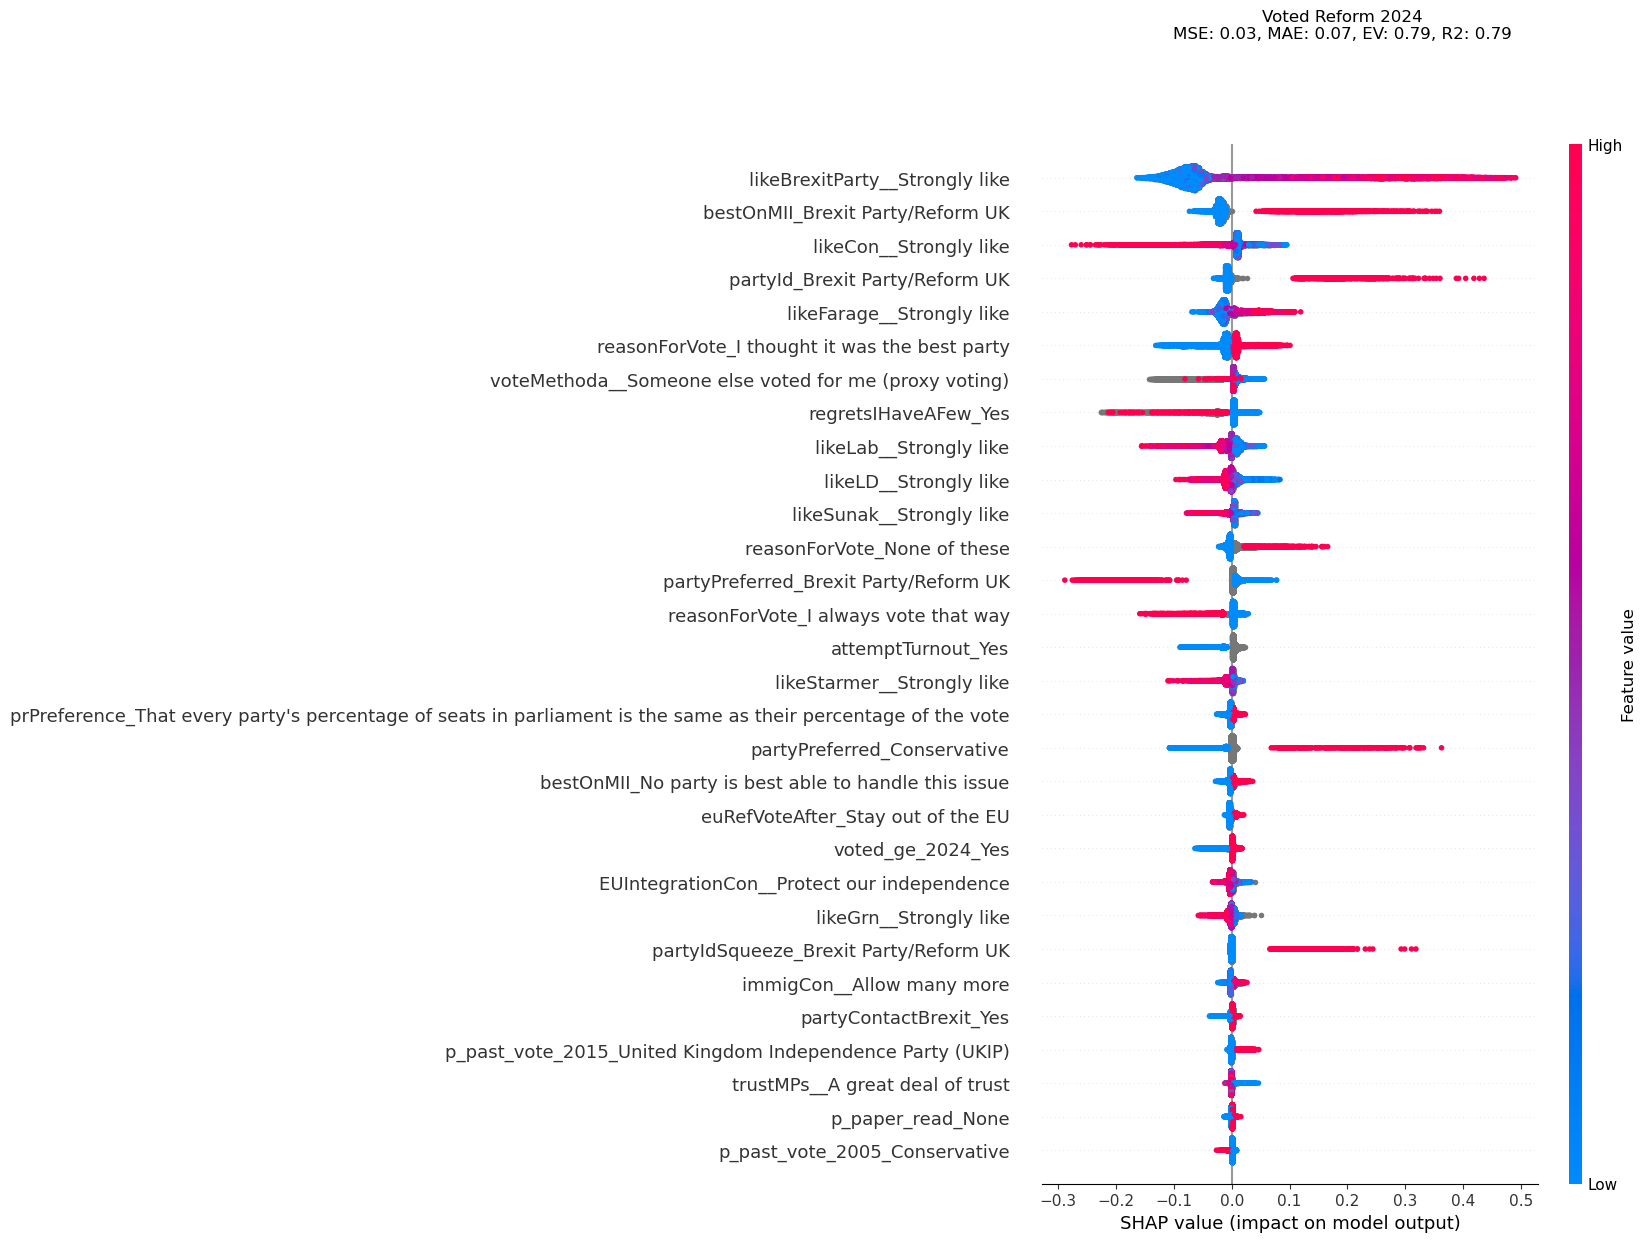

In [201]:
name="REF"

# BES_num[name] = BES_Panel[name].replace("Don't know",np.nan).cat.codes.replace(-1,np.nan).loc[BES_num.index]
df, corr_type = make_corr_summary(X, name)
display_corr(df,name,corr_type)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder,metrics) = xgboost_run(
    title = "Voted Reform 2024",dataset=X,
                                                    var_list = [name],var_stub_list = [name,        
                                                                                      
                                                                                      ],verbosity=0)

In [66]:
replace_dict = {'Labour':"LAB", 'Conservative':"CON", 'Brexit Party/Reform UK':"REF",
                  'Liberal Democrat':"LD", 'Green Party':"GP", 'Other':np.nan,
                  'An independent candidate':np.nan, "Don't know":np.nan,
                  'Scottish National Party (SNP)':np.nan, 'Plaid Cymru':np.nan}

y = BES_Panel["generalElectionVote"].astype('object')
y.loc[BES_Panel["genElecTurnoutRetro"]=='No, did not vote'] = "DNV"
y=y.replace(replace_dict).astype('category')

mask = (BES_Panel["country"]=="England")&y.notnull()
y=y[mask]

drop_string = "generalElectionVote|genElecTurnoutRetro|like|ptv|bestOnMII|leftRight|p_past_vote|partyId|disapprovalVote|partyContact|partyPreferred|reasonForVote|"+\
    "voteMethod|attemptTurnout|voted|regretsIHaveAFew|voterID|econGen|askedForID|p_eurefturnout|registered|achieve|redist(Con|Lab|LD|SNP|Brexit|Green)|"+\
    "(con|lab|ld|brexit|grn)LookAfter|(con|lab|ld|brexit|grn)(Trust|Competent)|(con|lab|ld|brexit|grn)_Ideas|EUIntegration(Con|Lab|LD|SNP|Green|Brexit)|"+\
    "immig(Con|Lab|LD|SNP|Brexit|Green)|pid|expectGoodConduct|ageGroup|changeView|prPreference|p_paper_read|participation|euref|euRefDoOver"

X = BES_reduced_with_na.drop(search(BES_reduced_with_na,drop_string).index,axis=1)[mask]
# X = X.dropna(axis=1)
# X = (X-X.mean())/X.std()
# keep_cols = X.columns[X.notnull().mean()>.6]
# X = X[keep_cols].fillna(X[keep_cols].mean())

# from tensorflow.keras.utils import to_categorical
# y = to_categorical(y.cat.codes)

# y = y=="REF"
# X["REF"] = y

y = BES_Panel["generalElectionVote"].astype('object')
y.loc[BES_Panel["genElecTurnoutRetro"]=='No, did not vote'] = "DNV"
y=y.replace(replace_dict).astype('category')
# y = BES_Panel["likeBrexitParty"].replace("Don't know",np.nan).cat.codes.replace(-1,np.nan)

mask = (BES_Panel["country"]=="England")&y.notnull()
y=y[mask]

orig_y = BES_Panel["generalElectionVote"].astype('object')
orig_y.loc[BES_Panel["genElecTurnoutRetro"]=='No, did not vote'] = "DNV"
orig_y=orig_y.replace(replace_dict).astype('category')[mask]

y = y.cat.codes.astype('category')
X["VOTE"] =y
# X["likeBXP"] = y

y_categories = ['CON', 'DNV', 'GP', 'LAB', 'LD', 'REF']



In [120]:
[x for x in X.columns if x in keep_vars.values]

['anyUniW26W27__Yes, I graduated from higher education',
 'polAttention__Pay a great deal of attention',
 'econPersonalProsp__Get a lot better',
 'econPersonalRetro__Got a lot better',
 'EUIntegrationSelf__Protect our independence',
 'satDemUK__Very satisfied',
 'satDemEng__Very satisfied',
 'redistSelf__Government should be less concerned about equal incomes',
 'immigSelf__Allow many more',
 'infoSourceTV__More than 2 hours',
 'infoSourcePaper__More than 2 hours',
 'infoSourceRadio__More than 2 hours',
 'infoSourceInternet__More than 2 hours',
 'infoSourcePeople__More than 2 hours',
 'trustMPs__A great deal of trust',
 'britishness__Very strongly British',
 'englishness__Very strongly English',
 'europeanness__Very strongly European',
 'lr1W27__Strongly agree',
 'lr2W27__Strongly agree',
 'lr3W27__Strongly agree',
 'lr4W27__Strongly agree',
 'lr5W27__Strongly agree',
 'al1W27__Strongly agree',
 'al2W27__Strongly agree',
 'al3W27__Strongly agree',
 'al4W27__Strongly agree',
 'al5W27__S

In [119]:
keep_vars

0      anyUniW26W27__Yes, I graduated from higher edu...
1            polAttention__Pay a great deal of attention
2                    econPersonalProsp__Get a lot better
3                    econPersonalRetro__Got a lot better
4            EUIntegrationSelf__Protect our independence
                             ...                        
148                           everUnionMemberW19_W26_Yes
149                    subjClassSqueezeW27_Working class
150                               disabilityChildW26_Yes
151                           noDependentsInHouseW26_Yes
152                              disabilityCensusW26_Yes
Length: 153, dtype: object

In [325]:
# search(BES_reduced_with_na,"immig")
# "immig(Con|Lab|LD|SNP|Brexit|Green)"

In [220]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y = le.fit_transform(y)

In [116]:
keep_vars

NameError: name 'keep_vars' is not defined

ACC: 0.55,  F1: 0.55


<Figure size 640x480 with 0 Axes>

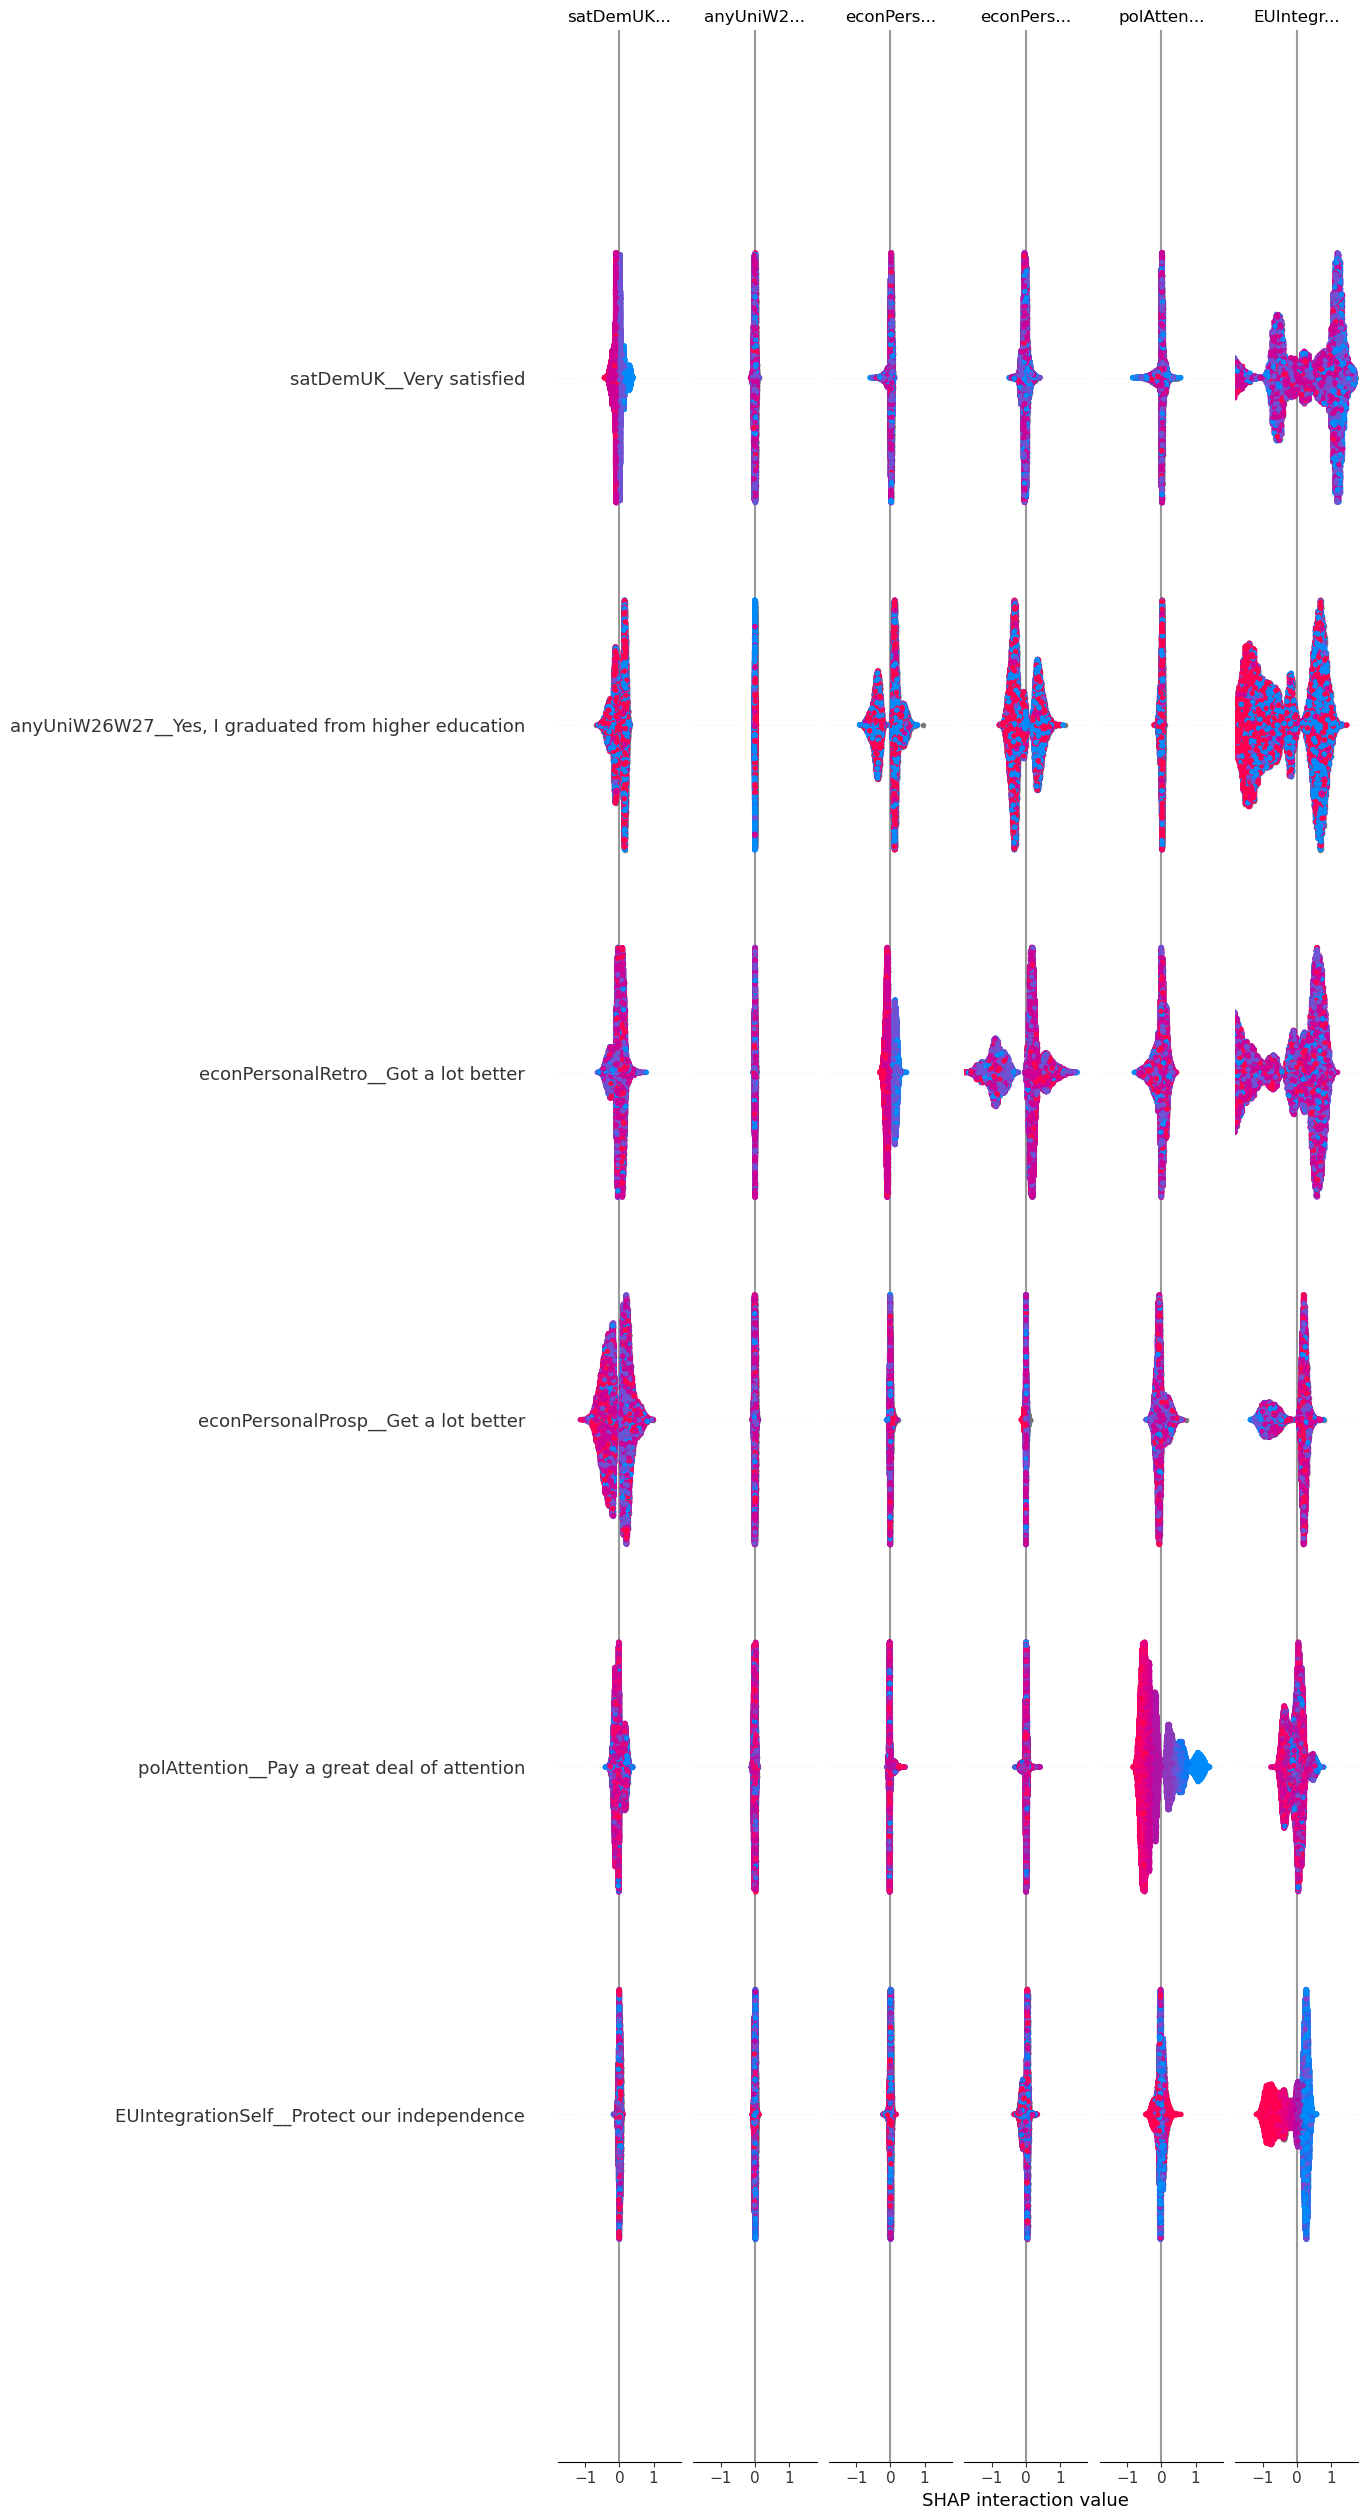

CPU times: total: 7min 11s
Wall time: 1min


In [67]:
%%time
name="VOTE"
# name="likeBXP"

# # BES_num[name] = BES_Panel[name].replace("Don't know",np.nan).cat.codes.replace(-1,np.nan).loc[BES_num.index]
# df, corr_type = make_corr_summary(X, name)
# display_corr(df,name,corr_type)

(explainer, shap_values, train_columns, train_index, alg,output_subfolder,metrics) = xgboost_run(
    title = "Voted Reform 2024",dataset=X,skip_bar_plot=True,
                                                    var_list = [name],var_stub_list = [name,        
                                                                                      
                                                                                      ],verbosity=0)

In [68]:
%%time
shap_expl = explainer(X.drop(name,axis=1))

CPU times: total: 4min 58s
Wall time: 39.6 s


In [12]:
%%time
clustering = shap.utils.hclust(X.drop(name,axis=1), y)

431it [22:03,  3.09s/it]                                                                                               

CPU times: total: 6h 57min 13s
Wall time: 22min 9s


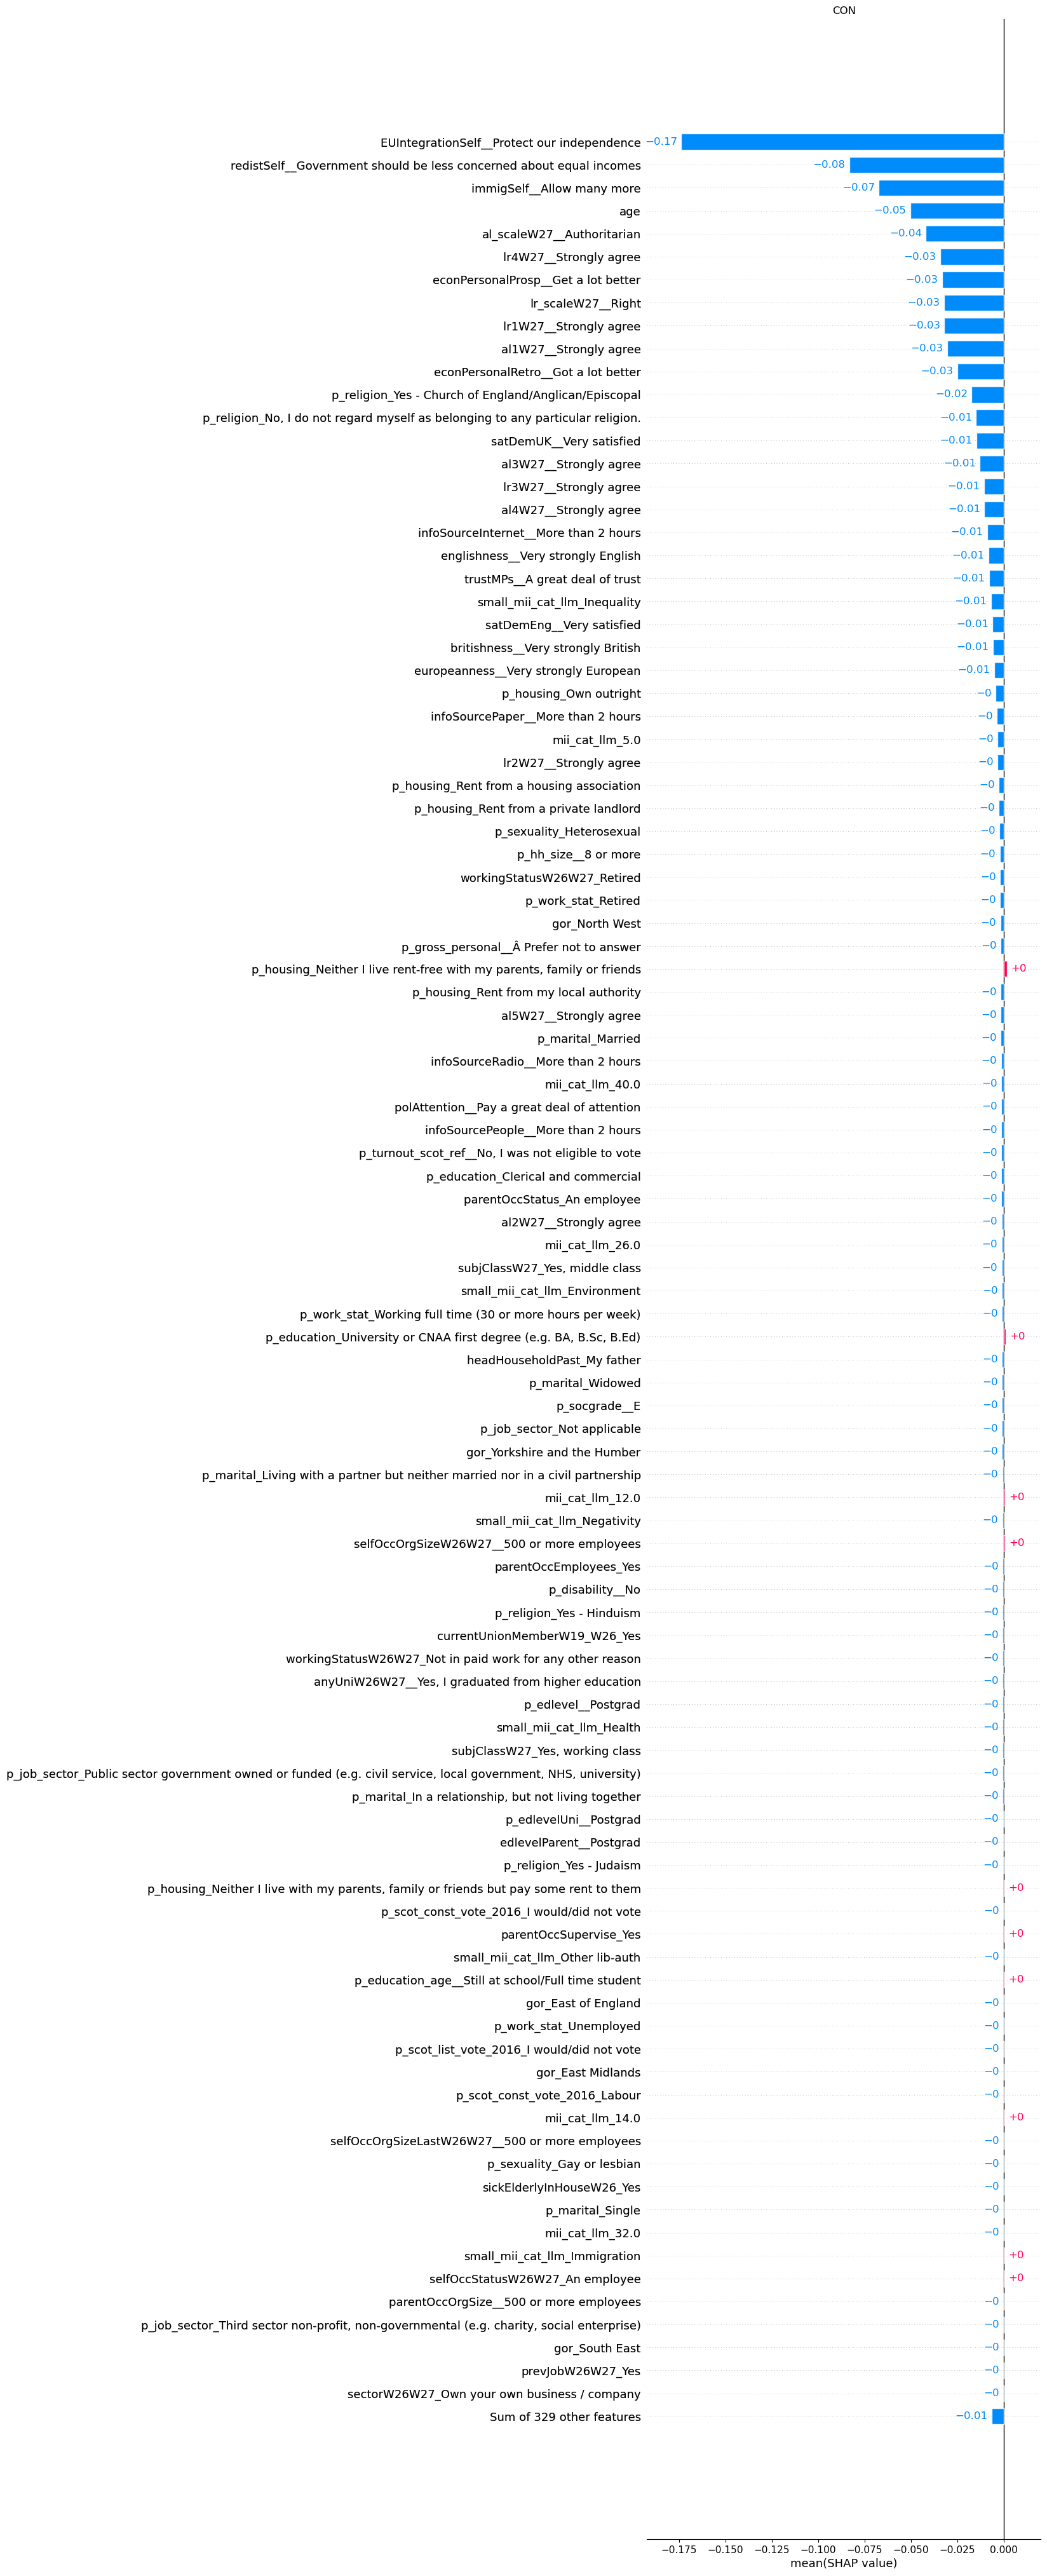

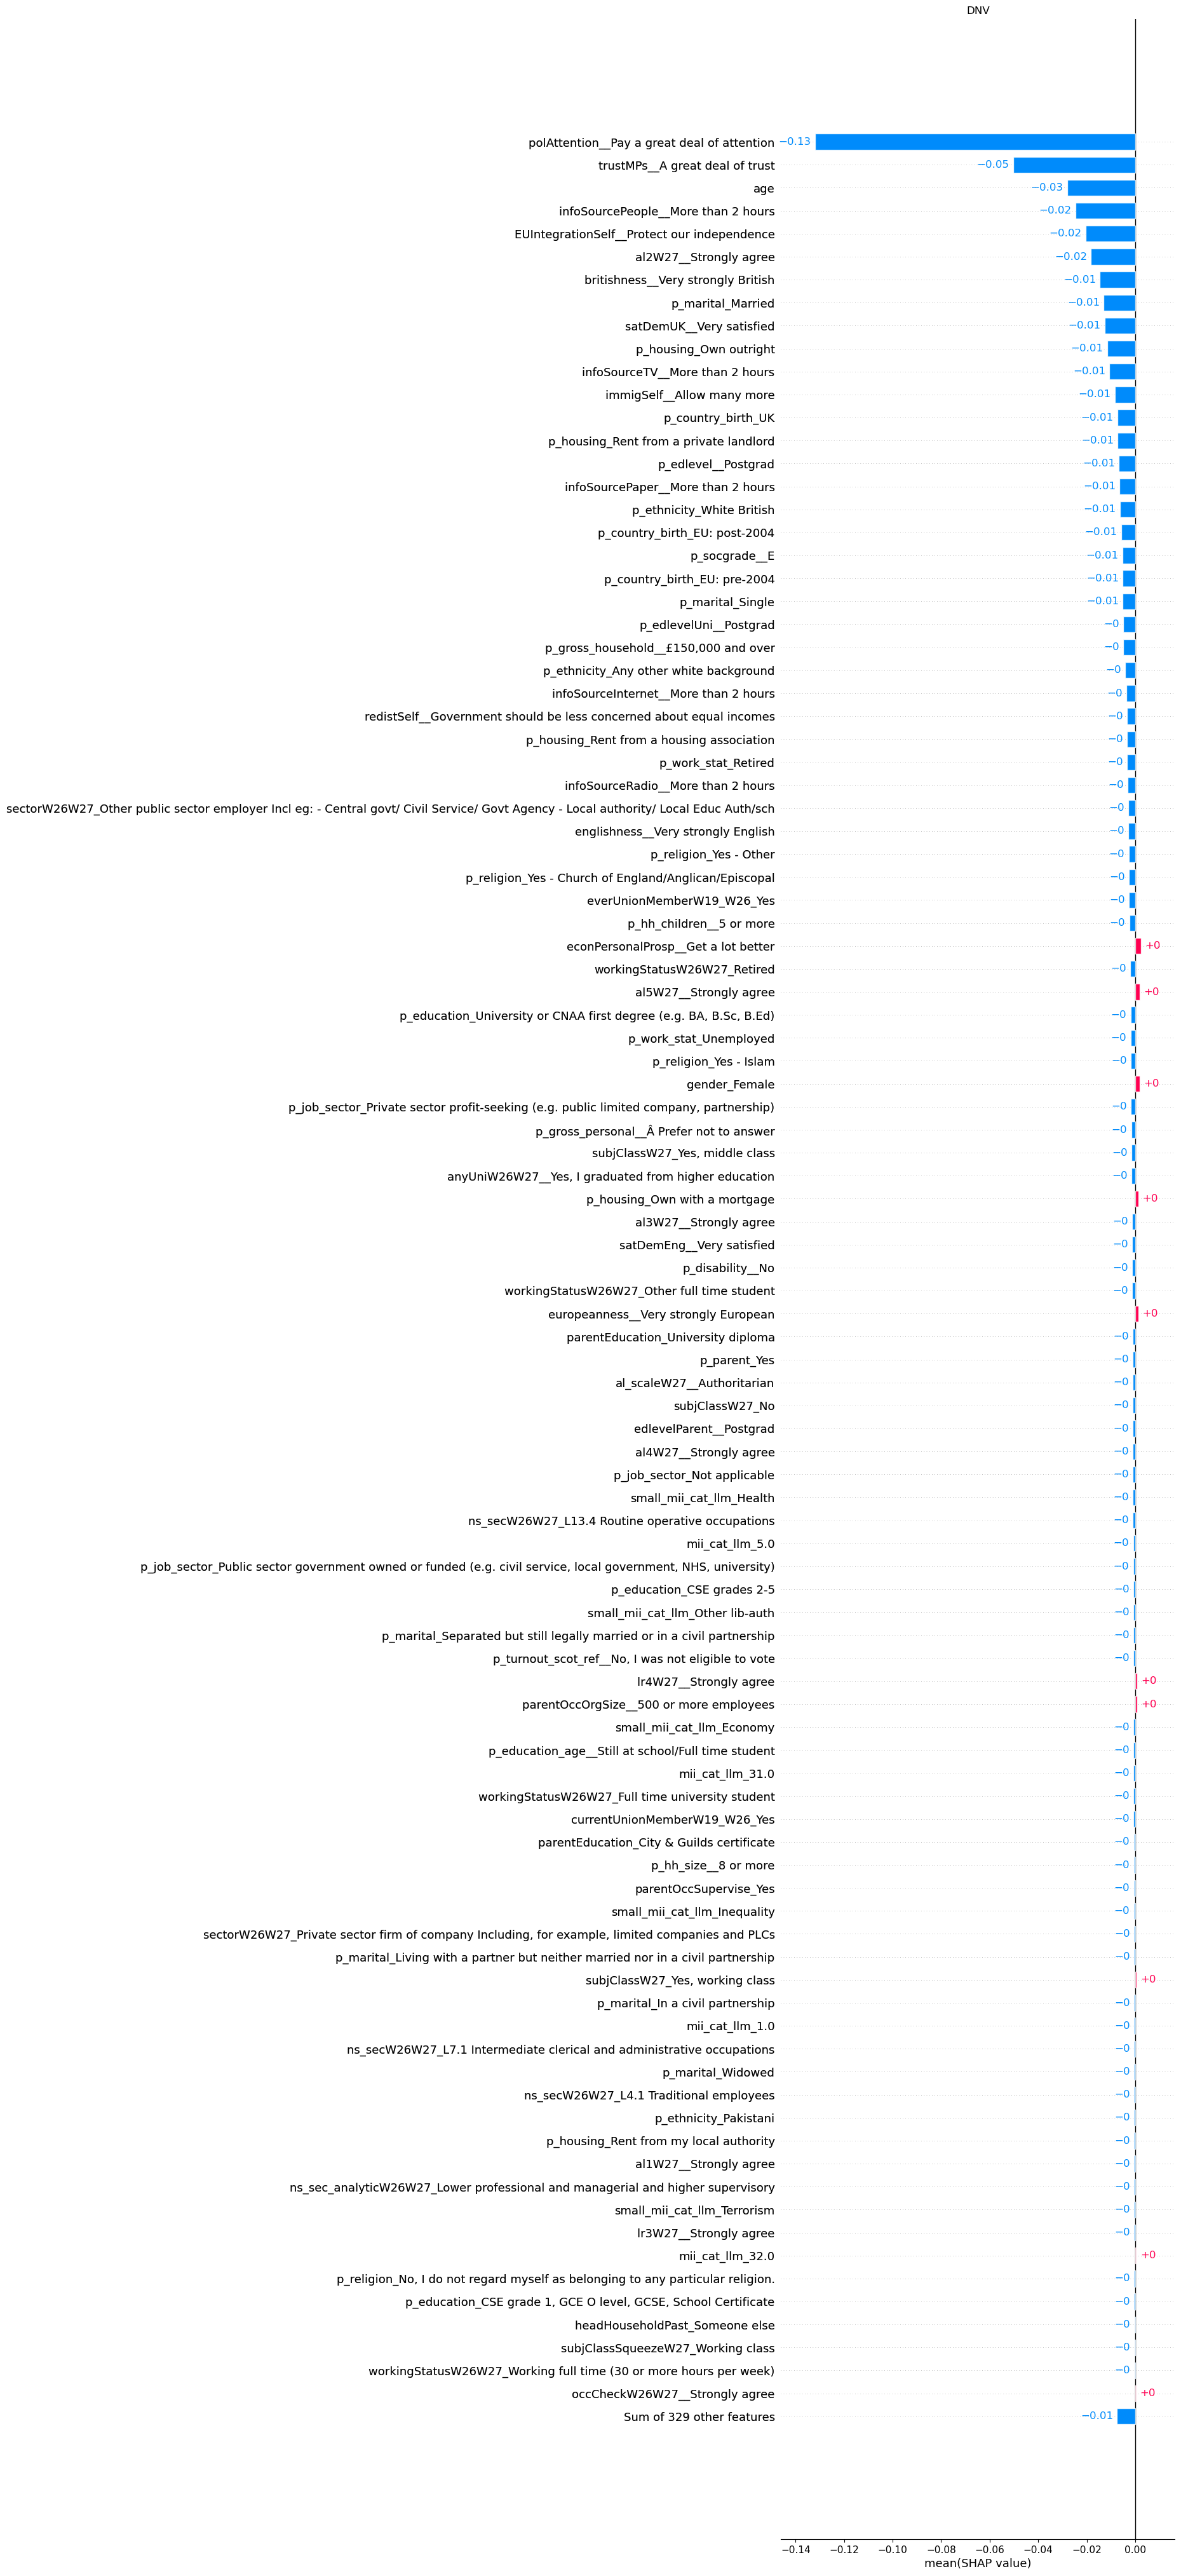

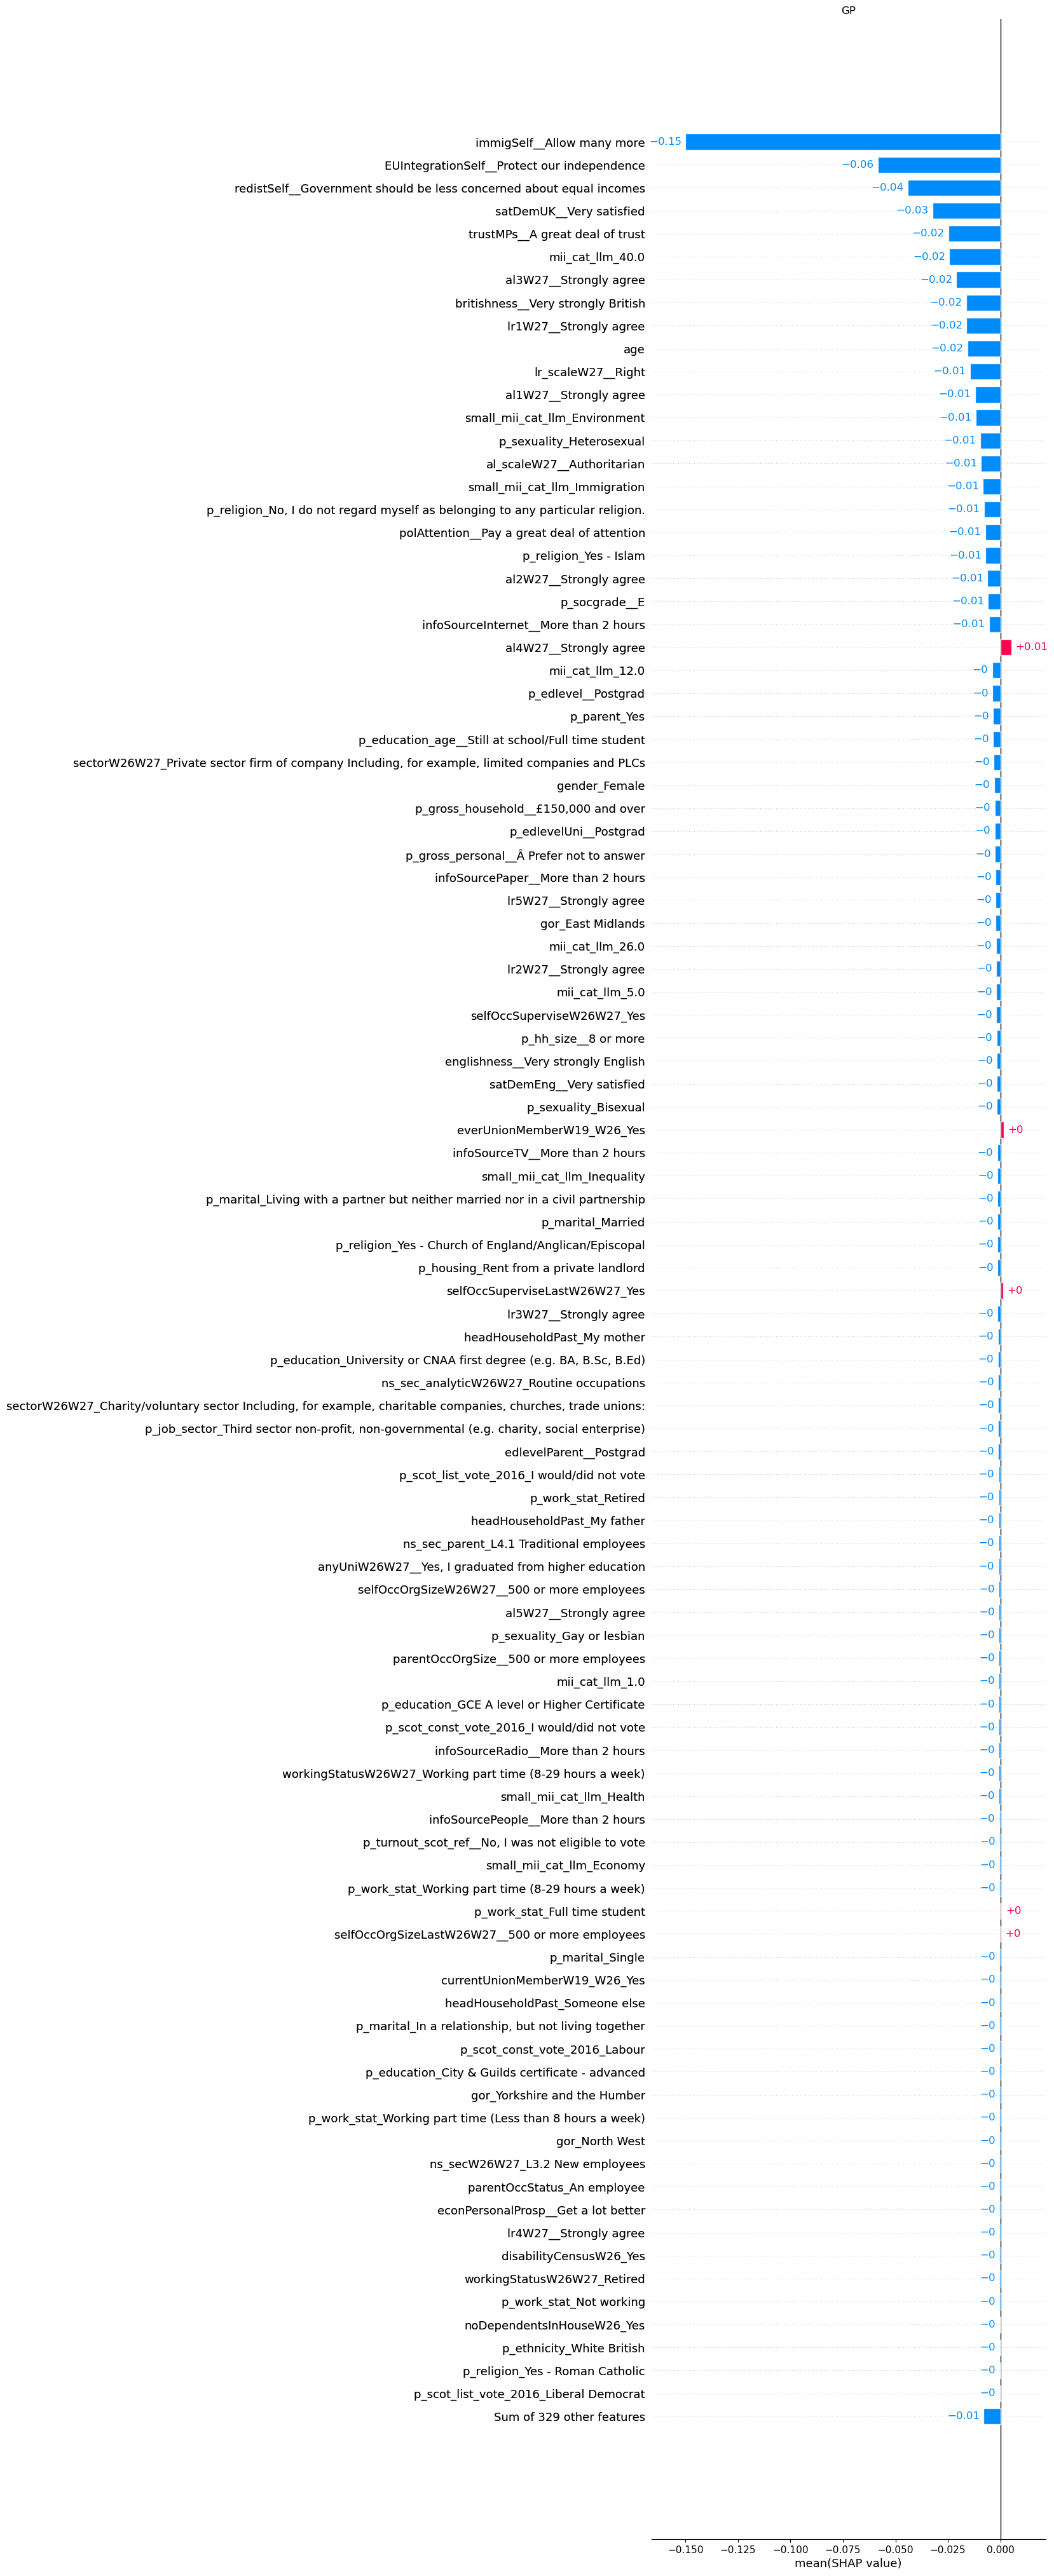

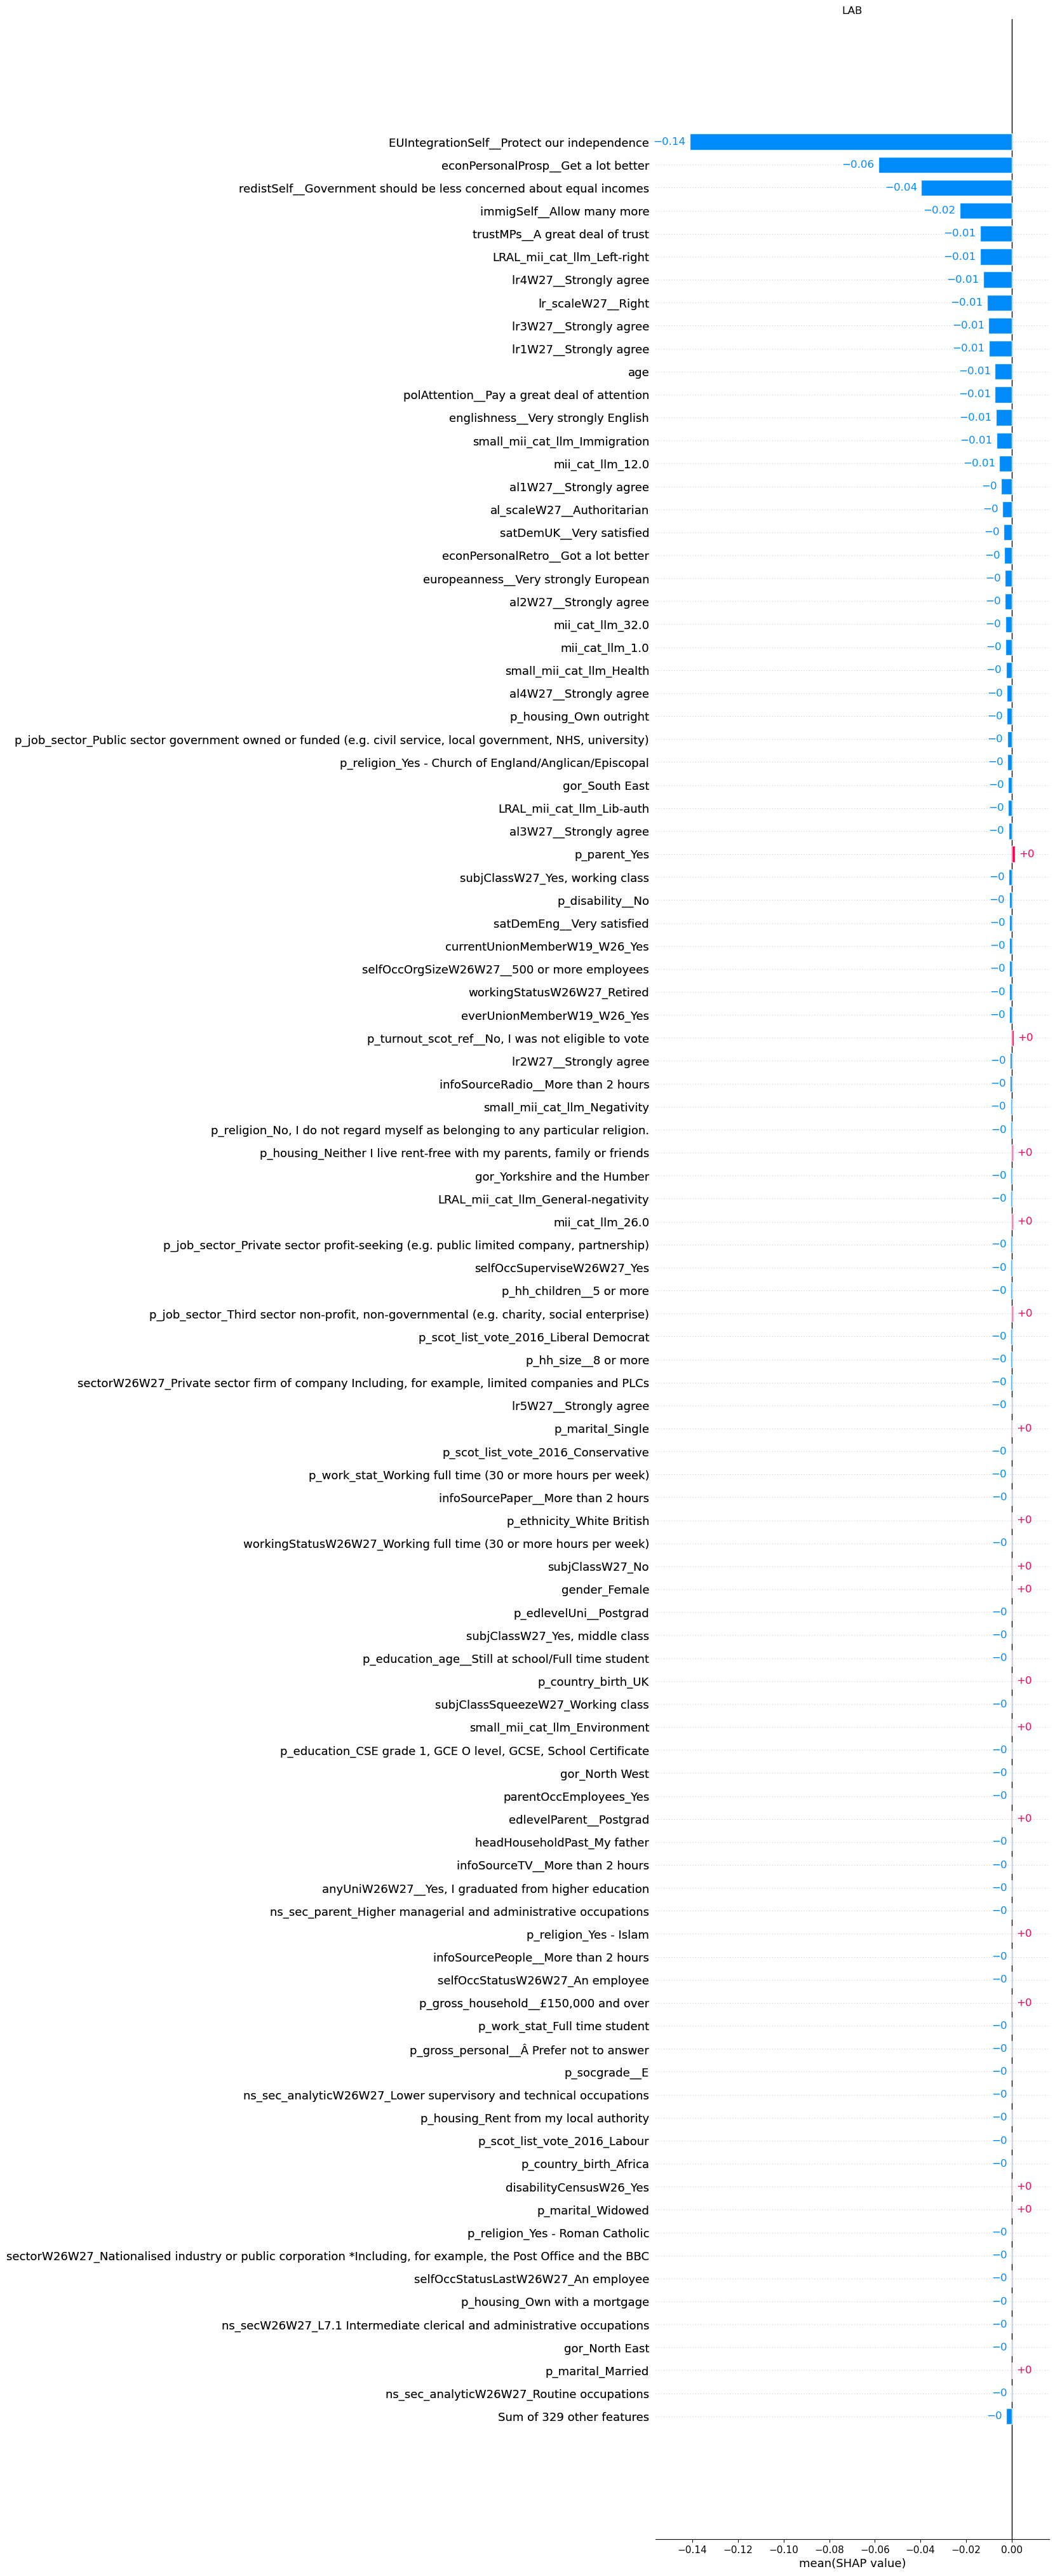

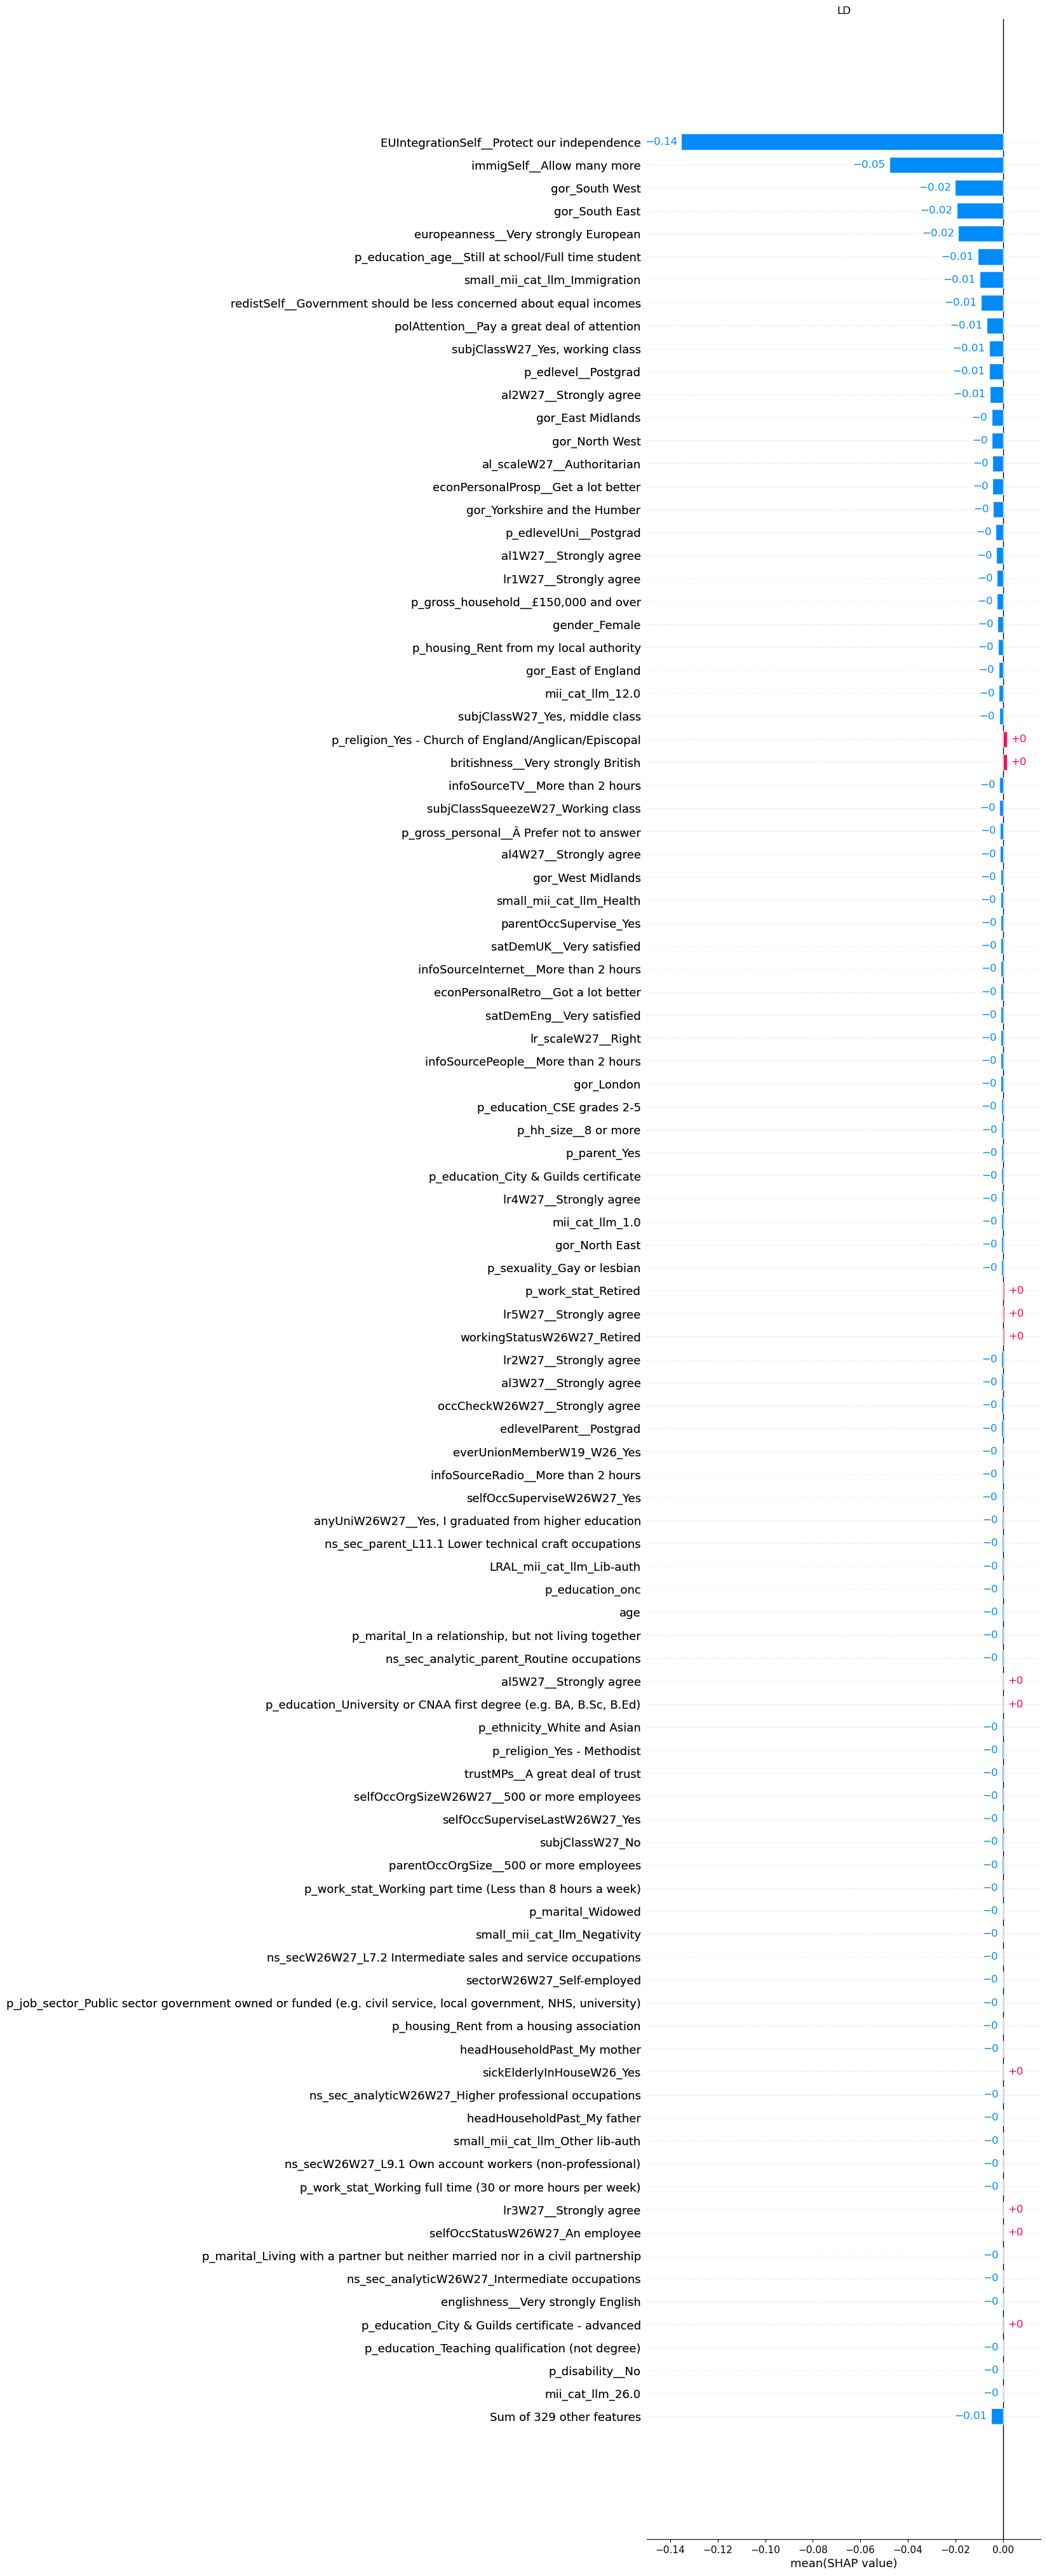

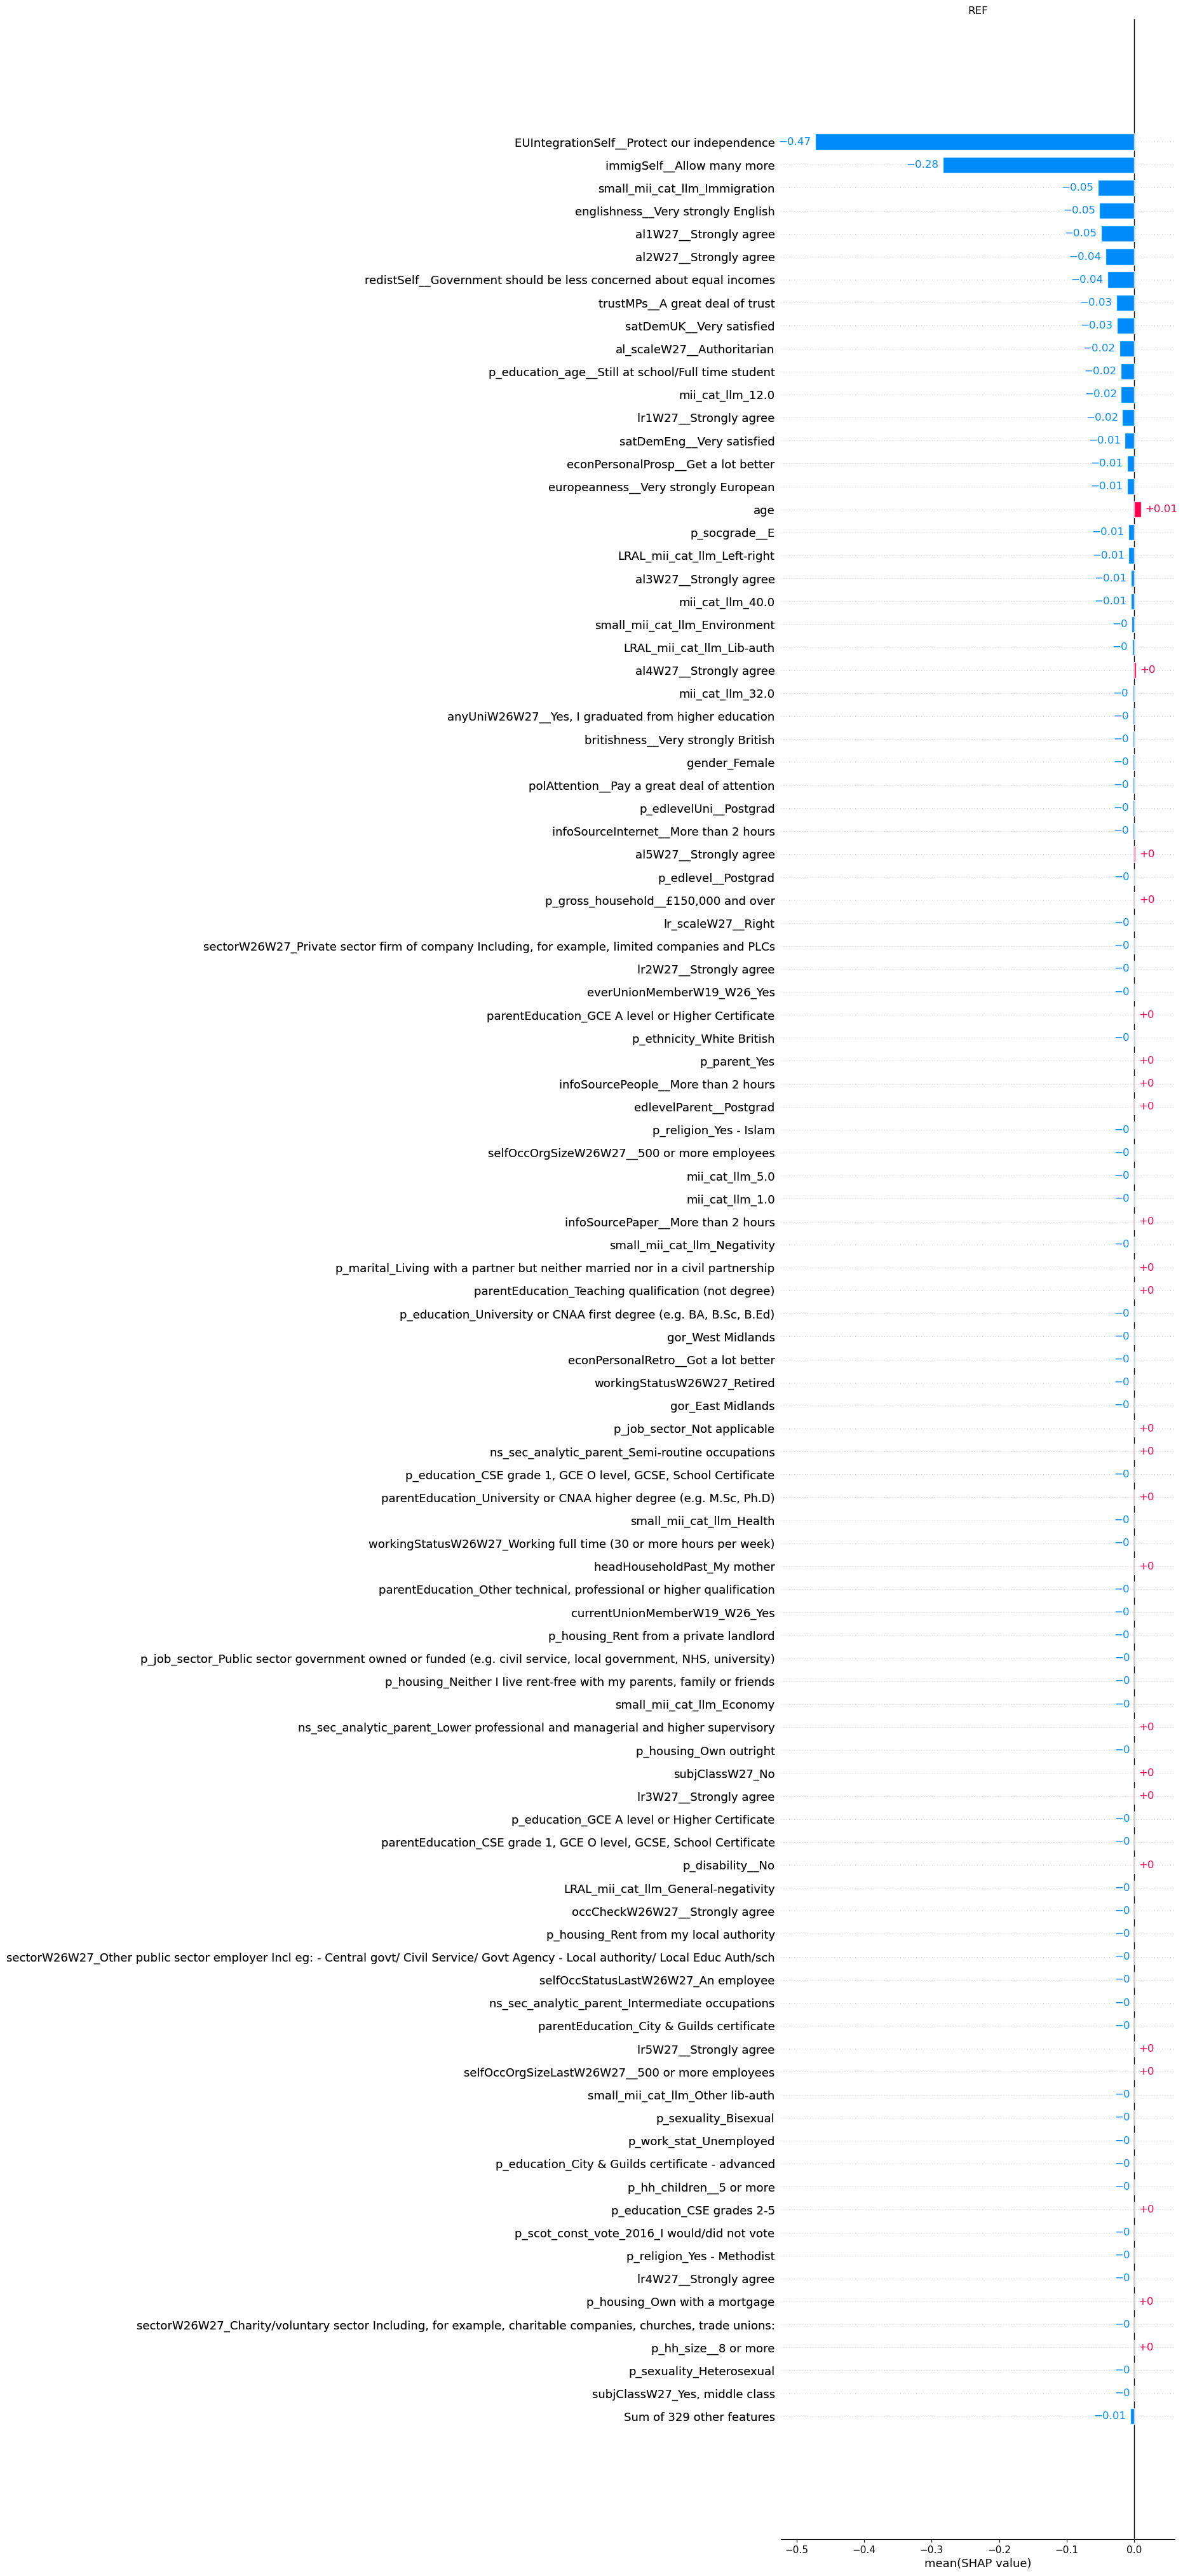

In [69]:
# y_categories
for ind in range(len(y_categories)):
    plt.title(y_categories[ind]);
    shap.plots.bar(shap_expl[:, :, ind].mean(0),max_display=100);
                   #, clustering=clustering);
    plt.show();

In [37]:
predictions = alg.predict(X.drop("VOTE",axis=1))

predictions = pd.Series([y_categories[x] for x in predictions])
predictions.index = orig_y.index

In [42]:
(orig_y==predictions).groupby(orig_y).mean().sort_values()

generalElectionVote
LD     0.396509
GP     0.405618
DNV    0.636257
REF    0.738577
CON    0.794572
LAB    0.888792
dtype: float64

In [49]:
(orig_y==predictions).groupby(predictions).mean().sort_values()

LAB    0.692233
CON    0.709786
DNV    0.727608
REF    0.734711
LD     0.769510
GP     0.833718
dtype: float64

In [48]:
(pd.crosstab(orig_y,predictions,normalize='index').round(2)*100).astype(int)

col_0                CON  DNV  GP  LAB  LD  REF
generalElectionVote                            
CON                   79    3   0    8   2    8
DNV                    9   64   1   16   2    8
GP                     6    6  41   40   5    2
LAB                    4    3   1   89   2    2
LD                    11    4   2   41  40    3
REF                   16    5   0    6   0   74

In [91]:
mean_df = pd.DataFrame()
std_df = pd.DataFrame()
for ind in range(len(y_categories)):

    temp = pd.DataFrame(shap_expl[:,:,ind].values,columns=X.columns[:-1]).abs().agg(["mean","std"]).T
    mean_df[y_categories[ind]+"_mean"]=temp["mean"]
    std_df[y_categories[ind]+"_std"]=temp["std"]


In [107]:
mean_df.mean(axis=1).sort_values(ascending=False).head(50)

EUIntegrationSelf__Protect our independence                                       0.406553
immigSelf__Allow many more                                                        0.280942
redistSelf__Government should be less concerned about equal incomes               0.144022
trustMPs__A great deal of trust                                                   0.116831
polAttention__Pay a great deal of attention                                       0.113430
age                                                                               0.089249
econPersonalProsp__Get a lot better                                               0.089040
satDemUK__Very satisfied                                                          0.084894
econPersonalRetro__Got a lot better                                               0.056288
lr1W27__Strongly agree                                                            0.048449
al1W27__Strongly agree                                                            0.046667

In [104]:
mean_df.mean(axis=1).sort_values(ascending=False)[50:].head(50)

p_edlevelUni__Postgrad                                                                                                                  0.013408
lr2W27__Strongly agree                                                                                                                  0.011827
p_sexuality_Heterosexual                                                                                                                0.011703
sectorW26W27_Private sector firm of company Including, for example, limited companies and PLCs                                          0.011353
p_housing_Rent from a private landlord                                                                                                  0.011001
edlevelParent__Postgrad                                                                                                                 0.010807
subjClassW27_Yes, middle class                                                                                                    

<Axes: >

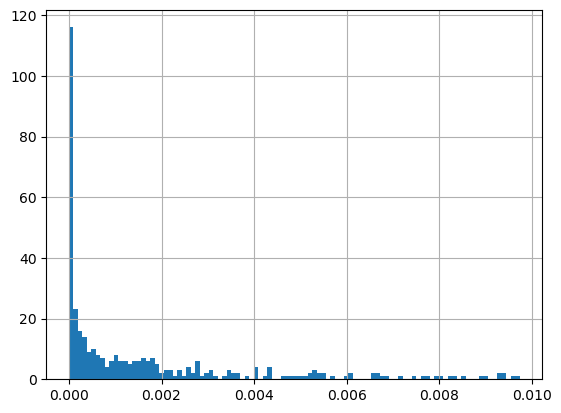

In [108]:
mean_df.mean(axis=1)[mean_df.mean(axis=1)<.01].hist(bins=100)

In [113]:
pd.Series(mean_df.mean(axis=1)[mean_df.mean(axis=1)>.002].index ).to_csv("keep_vars.csv")

In [117]:
keep_vars = pd.Series(mean_df.mean(axis=1)[mean_df.mean(axis=1)>.002].index )

In [ ]:
# shap_value_summary = explainer.shap_values(feature_train)
ensured_list_shap_values = [shap_expl[:,:,i] for i in range(shap_expl.shape[2])]
shap.summary_plot(ensured_list_shap_values)

In [ ]:
shap.summary_plot(shap_expl, plot_type="bar")

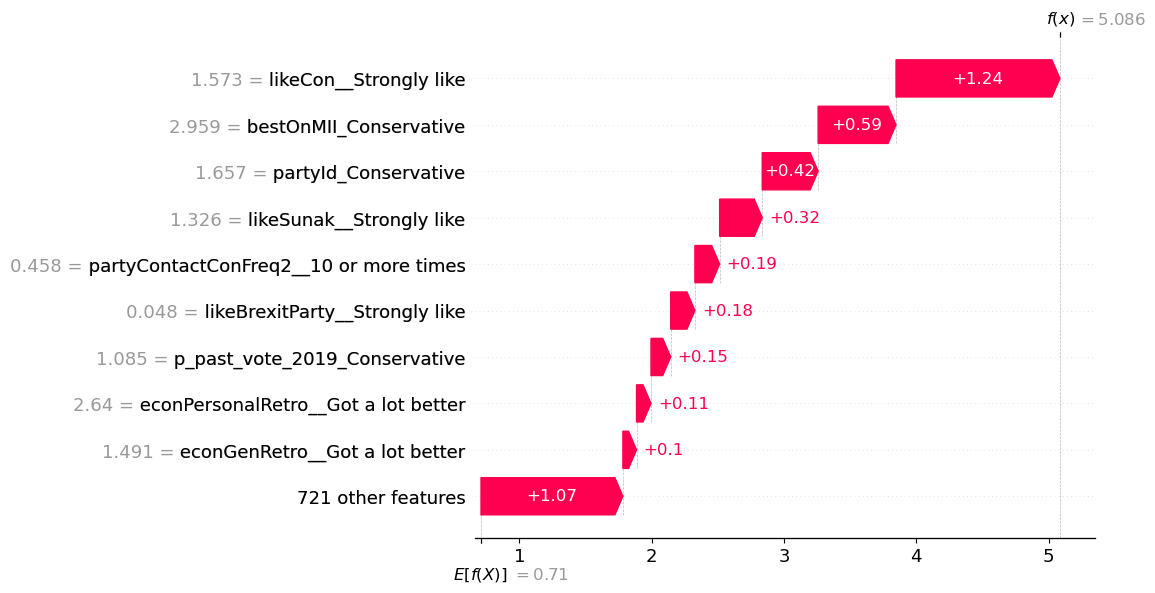

In [293]:
# shap.plots.bar(shap_expl[:,:,1])
shap.plots.waterfall(shap_expl[0,:,0])

In [307]:
shap_expl[k].values.shape

(730, 6)

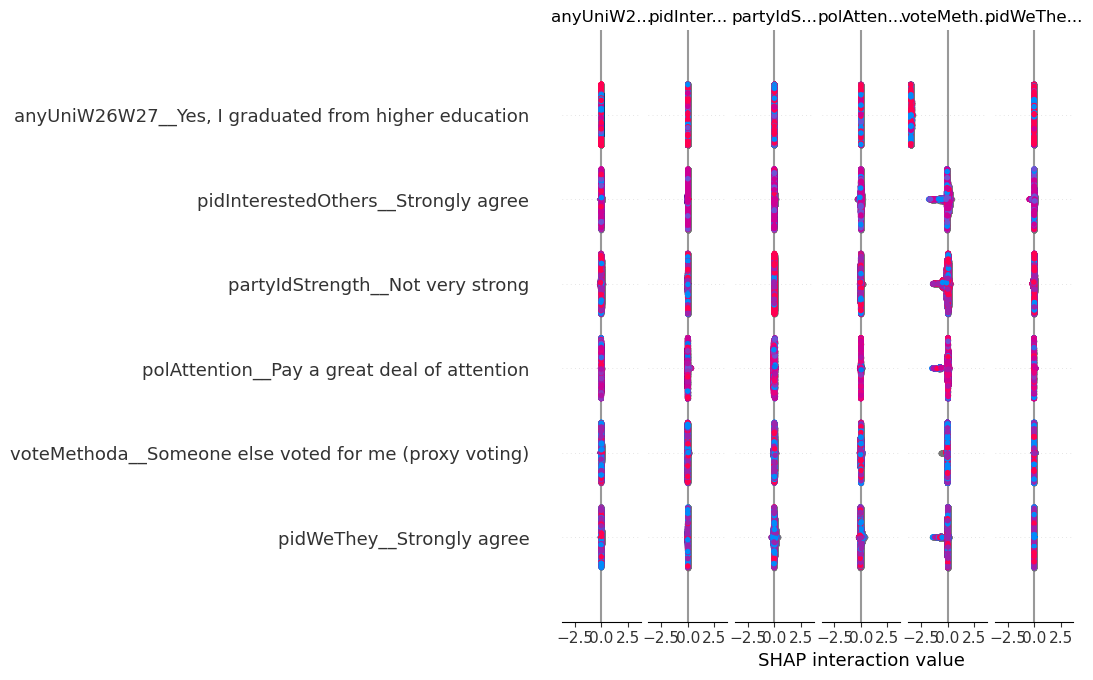

In [242]:
shap.summary_plot(shap_values, X.drop("VOTE",axis=1), plot_type="bar")

In [254]:
%%time
shap_expl = explainer(X.drop("VOTE",axis=1))

CPU times: total: 5min 7s
Wall time: 39.4 s


In [255]:
shap.plots.bar(shap_expl)

IndexError: list index out of range

In [257]:
import xgboost

import shap

# train XGBoost model
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

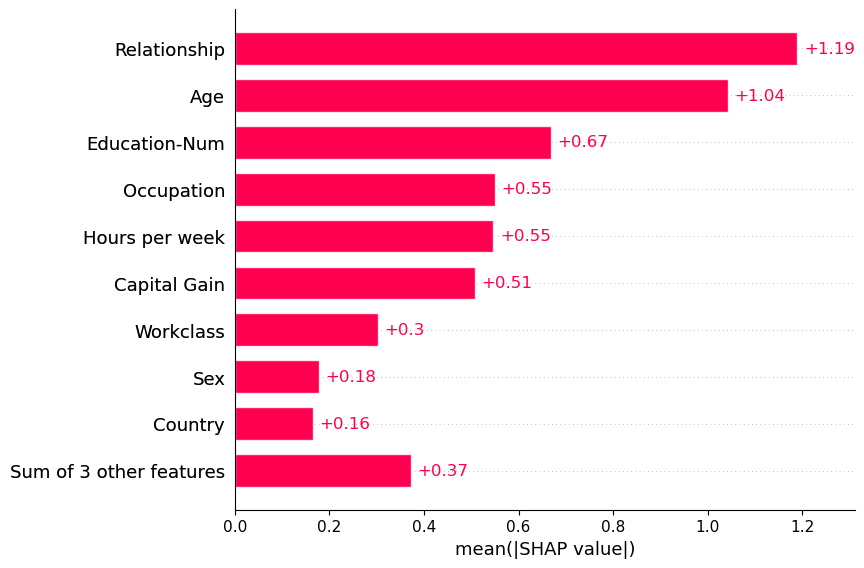

In [258]:
shap.plots.bar(shap_values)

In [8]:

import shap
import xgboost as xgb
# from sklearn.preprocessing import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score, log_loss,f1_score,roc_auc_score
import pickle

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None,save_shap_values=False,skip_bar_plot=False, multiclass=False,class_names=None,
                 plot_type='dot' ):


    #################################
#     threshold = .1
#     min_features = 30
    if not multiclass:

        global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
        n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                              min_features )
        n_top_features = min(n_top_features,global_shap_vals.shape[0])# can't display more features than present!
        
    #     if n_top_features <min_features:
    #         n_top_features = min_features

        ##########################

        inds = np.argsort(global_shap_vals)[-n_top_features:]

        y_pos = np.arange(n_top_features)
        
        if skip_bar_plot:
            plt.figure(figsize=(16,10))
            plt.title(target_var);
            plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
            plt.yticks(y_pos, train.columns[inds])
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.xlabel("mean SHAP value magnitude (change in log odds)")
            plt.gcf().set_size_inches(6, 4.5)

            plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

            plt.show()
    else: ## multiclass
        n_top_features = min(min_features,train.shape[1])# can't display more features than present!
        plot_type='bar'
       # class_names=["your","list","of", "class", "names"]

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        

       
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type=plot_type, class_names=class_names );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
    if save_shap_values:     
        pd.DataFrame(shap_values, columns = train.columns, index=train.index).to_pickle(output_subfolder+ "shap_values.zip", compression='zip')


objective = 'reg:squarederror'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1            
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size,
                             eval_metric, 
                              verbose = True,
                              sample_weights = None,plot_validation=False):

    enable_categorical=False
    if target.dtype.name == 'category':
        stratification = target.cat.codes
        # enable_categorical=True
    elif len(pd.unique(target))<=10:
        stratification = target
    else:
        stratification = pd.qcut( pd.Series( target ), q=10, duplicates = 'drop', ).cat.codes

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify= stratification)

        eval_set = [(X_train, y_train), (X_test, y_test)]
        weight_var = sample_weights.name
        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)
        
        alg.fit(X_train, y_train, 
                # eval_metric=eval_metric, 
                # early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=verbose, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=stratification )
          
            

        eval_set = [(X_train, y_train), (X_test, y_test)]

        alg.fit(X_train, y_train,
                # enable_categorical=enable_categorical,
                # eval_metric=eval_metric, 
                # early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=verbose )        
        

    

    def scale(x):
        return (np.array(x)-min(x))/(max(x)-min(x))
    if plot_validation:
        results = alg.evals_result()
        epochs = len(results['validation_0'][eval_metric[0]])
        x_axis = range(0, epochs)
        plt.figure(figsize=(14,8));
        color = iter(cm.rainbow(np.linspace(0, 1, len(eval_metric))))
        for metric in eval_metric:
            col = next(color)
            plt.plot(x_axis, np.log(scale(results['validation_0'][metric])), label=metric,marker='*',c=col)
            plt.plot(x_axis, np.log(scale(results['validation_1'][metric])), label=metric,marker='s',c=col)
            
        plt.axvline(alg.best_iteration);
        plt.legend();
        plt.title('XGBoost Validation Errors');
        plt.show();
    
    alg.set_params(n_estimators=alg.best_iteration)    
    
    # make predictions for test data
    # belt and bracers!
    predictions = alg.predict(X_test,iteration_range=(0, alg.best_iteration + 1))

    
    if target.dtype.name == 'category':
        ACC = accuracy_score(y_test, predictions)
        ##NLL = log_loss(y_test, predictions)
        F1 = f1_score(y_test, predictions,average='micro')
        ##ROCAUC = roc_auc_score(y_test, predictions)

        print("ACC: %.2f,  F1: %.2f"  % (ACC,  F1,) )   
           
        return (ACC, F1, alg.best_iteration)

    
    else:
    # evaluate predictions
        MSE = mean_squared_error(y_test, predictions)
        MAE = mean_absolute_error(y_test, predictions)
        EV = explained_variance_score(y_test, predictions)
        R2 = r2_score(y_test, predictions)

        print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
  
        return (MSE, MAE, EV, R2, alg.best_iteration)

def shap_array(shap_values, train_columns, threshold = .1, min_features = 50):

    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    return pd.Series(global_shap_vals[inds][::-1],index = train_columns[inds][::-1])
    
# def shap_df(shap_values, train_columns, train_index, threshold = .1, min_features = 50):

    # global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    # n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          # min_features )

    # inds = np.argsort(global_shap_vals)[-n_top_features:]

    # return pd.Series(global_shap_vals[inds][::-1],index = train_columns[inds][::-1])
    

    
def get_generic_weights(BES_Panel):
    weight_vars = list(search(BES_Panel,"(wt_new_W\d+|wt_full_W\d)($|_result)").index)
    sample_weights = BES_Panel[weight_vars].mean(axis=1)
    sample_weights = sample_weights.fillna(sample_weights.median())
    sample_weights.name = "sample_weights"    
    return sample_weights
    

    

def get_xgboost_alg(
     learning_rate =0.05,
     n_estimators= 500,
     max_depth=6,
     min_child_weight=6,
     gamma=0.00065, # aka min_split_loss
     subsample=0.8,
     colsample_bytree=0.7,
     colsample_bylevel=.9,
     colsample_bynode=.85,
     objective= 'reg:squarederror',
     eval_metric = 'rmse',

   #  scale_pos_weight=1.09,
     reg_alpha=1.075,
     reg_lambda=1.011,
     sketch_eps=0.0,
     refresh_leaf=0,
     nthread=8,
     n_jobs =8,
     random_state=27**2, 
     base_score =.5,
     scale_pos_weight = 1,
     classification_problem = False):

    early_stopping_rounds = n_estimators*early_stoppping_fraction
    
     
    if classification_problem==False:
        alg = XGBRegressor(
         learning_rate =learning_rate,
         n_estimators= n_estimators,
         max_depth = max_depth,
         min_child_weight = min_child_weight,
         gamma = gamma,
         subsample = subsample,
         colsample_bytree = colsample_bytree,
         colsample_bylevel = colsample_bylevel,
         colsample_bynode = colsample_bynode,
         objective = objective,
         eval_metric = eval_metric,
         early_stopping_rounds = early_stopping_rounds,            
         scale_pos_weight = scale_pos_weight,
         reg_alpha=reg_alpha,
         reg_lambda=reg_lambda,
         sketch_eps=sketch_eps,
         refresh_leaf=refresh_leaf,
         nthread = nthread,
         n_jobs  = n_jobs ,
         random_state = random_state,
         base_score=base_score)
    else:
        alg = XGBClassifier(
         enable_categorical=True,
         learning_rate =learning_rate,
         n_estimators= n_estimators,
         max_depth = max_depth,
         min_child_weight = min_child_weight,
         gamma = gamma,
         subsample = subsample,
         colsample_bytree = colsample_bytree,
         colsample_bylevel = colsample_bylevel,
         colsample_bynode = colsample_bynode,
         objective = objective,
         eval_metric = 'mlogloss',       
         early_stopping_rounds = early_stopping_rounds,
         scale_pos_weight = scale_pos_weight,
         reg_alpha=reg_alpha,
         reg_lambda=reg_lambda,
         sketch_eps=sketch_eps,
         refresh_leaf=refresh_leaf,
         nthread = nthread,
         n_jobs  = n_jobs ,
         random_state = random_state,
         base_score=base_score)        
    return alg
    
    
    
#global var_list
def xgboost_run(title, dataset, var_list,var_stub_list=[], subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default",
                use_specific_weights = None, automatic_weights_from_wave_no = False, alg = None,verbosity=1,skip_bar_plot=False,
                eval_metric = ['rmse'],minimum_sample=50,dont_stop_on_sample_size_err=False,print_shap_chart=True,plot_validation=False,
                threshold=.1):

    # global BES_Panel
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    
    for target_var in var_list:

        if dataset[target_var].dtype=='category':
            classification_problem = True
        else:
            classification_problem = False
    
        if alg is None:
            alg = get_xgboost_alg(classification_problem=classification_problem) # removing eval_metric link!
            alg.verbosity=verbosity
        if verbosity>=1:
            verbose=True
        else:
            verbose=False
        
        if automatic_weights_from_wave_no:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(dataset,target_var)
        mask   = target.notnull()
        if optional_mask & automatic_weights_from_wave_no:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            print("Skipping - sample size beneath minimum: ",minimum_sample)
            skipping = True
            if not dont_stop_on_sample_size_err:
                raise Exception("fgflgf")
            continue
        skipping=False

        train = create_train(dataset,drop_other_waves,var_stub_list,mask,target_var)

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if use_specific_weights is not None:
            sample_weights = use_specific_weights[mask].fillna(use_specific_weights[mask].median())




        elif automatic_weights_from_wave_no:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        if target.dtype.name == 'category':
            (ACC,  F1, alg_best_iteration) = get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = verbose,
                                      sample_weights=sample_weights,plot_validation=plot_validation)
            pd.Series([ACC,  F1,  alg_best_iteration],index = ["ACC",  "F1", "alg_best_iteration"]).to_csv(output_subfolder+"scores.csv")
           
        
        else:

            (MSE, MAE, EV, R2, alg_best_iteration) = get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = verbose,
                                      sample_weights=sample_weights,plot_validation=plot_validation)
            pd.Series([MSE, MAE, EV, R2, alg_best_iteration],index = ["MSE", "MAE", "EV", "R2", "alg_best_iteration"]).to_csv(output_subfolder+"scores.csv")
                                        
        # fit to full dataset at non-overfitting level
        early_stopping_rounds_save = alg.get_params()["early_stopping_rounds"]
        alg.set_params(early_stopping_rounds=0) 
        alg.fit(train, target, verbose = verbose, sample_weight = sample_weights)
        alg.set_params(early_stopping_rounds=early_stopping_rounds_save) 


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        pickle.dump( explainer, open( output_subfolder+"explainer.pkl", "wb" ) )
        pickle.dump( explainer, open( output_subfolder+"alg.pkl", "wb" ) )

        if target.dtype.name == 'category':
            subtitle = "ACC: %.2f, F1: %.2f" % (ACC, F1)
            metrics = (ACC, F1)
        else:
            subtitle = "MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2)
            metrics = (MSE, MAE, EV, R2)
            
        
            
        if target.dtype.name == 'category':
            multiclass = True
            class_names = list(target.cat.categories)
        else:
            multiclass = False
            class_names = None
            
        if print_shap_chart:
            shap_outputs(shap_values, train, target_var, output_subfolder, threshold = threshold,
                     min_features = min_features, title=title+"\n"+subtitle,
                     dependence_plots=dependence_plots,skip_bar_plot=False,multiclass=multiclass,class_names=class_names)        

    if skipping:
        return (None,None,None,None,None,None,None)
    else:
        return (explainer, shap_values, train.columns, train.index, alg,output_subfolder,metrics)






############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1

def create_train(dataset,drop_other_waves,var_stub_list,mask,target_var):
    keep_list = dataset.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
    
    keep_list = list(keep_list)
    keep_list.remove(target_var)
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return dataset[keep_list][mask]

def create_target(dataset,target_var):
    return dataset[target_var]

